In [2]:
# pip install ase dscribe matplotlib seaborn scikit-learn tensorflow
# pip install --upgrade pip
# pip install tensorflow

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from dscribe.descriptors import SOAP
from ase.io import read, write
import seaborn as sns
%matplotlib inline

In [4]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import to_categorical

#from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1, L2

from sklearn.decomposition import KernelPCA
from matplotlib.colors import Normalize

In [5]:
path_to_POSCAR_MBT = 'DFT_CONTCARs_MBT/'

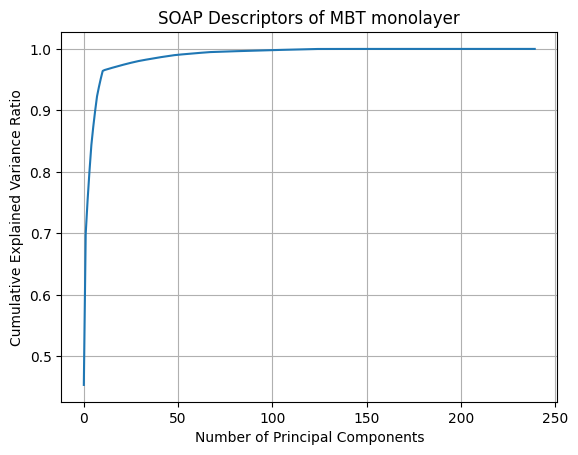

In [6]:
## Read POSCARs file and extract the information
def read_POSCAR(file_path):

    poscar_info_list = []
    atomic_species_list = []
    unique_atomic_species_list = set()
    
    for file in os.listdir(file_path):
        if file.endswith('.vasp'):
            poscar_path = os.path.join(file_path, file)
            poscar = read(poscar_path, format = 'vasp')
            poscar_info_list.append(poscar)
            atomic_species_list.append(poscar.get_chemical_symbols())
            for atoms in atomic_species_list:
                unique_atomic_species_list.update(poscar.get_chemical_symbols())
    return poscar_info_list, atomic_species_list, list(unique_atomic_species_list)

poscar_info_list, atomic_species_list, unique_atomic_species_list = read_POSCAR(path_to_POSCAR_MBT)

## Extract the SOAP descriptors
def get_SOAP_descriptor(poscar_info_list, r_cut, n_max, l_max):
    
    poscar_info_list,_,unique_atomic_species_list = read_POSCAR(path_to_POSCAR_MBT)
    soap = SOAP(species = unique_atomic_species_list,
               r_cut = r_cut,
               n_max = n_max,
               l_max = l_max,
                sigma = 0.5,    # default: 1.0
                rbf = 'gto',    # deafult: 'gto'
                average='inner',  # default: 'off'
                periodic=True,  # default: False
                sparse=False)    # default: False
    soap_desc = []
    for struct in poscar_info_list:
        soap_struct = soap.create(struct)
        soap_desc.append(soap_struct)
    return np.vstack(soap_desc)

## call the SOAP function
soap_desc = get_SOAP_descriptor(poscar_info_list, 9.0, 6, 5)

## Plot the PCA variance to determine the number of principal components
def plot_PCA_variance(soap_desc, n_components):
    pca = PCA(n_components = n_components)
    pca.fit(soap_desc)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('SOAP Descriptors of MBT monolayer')
    plt.grid(True)
    plt.show()
    
plot_PCA_variance(soap_desc,240)

In [7]:
def perform_pca(soap_desc, optimal_components):
    pca = PCA(n_components = optimal_components)
    soap_pca = pca.fit_transform(soap_desc)
    return soap_pca

optimized_pca = perform_pca(soap_desc,100)
scaler = StandardScaler()
X = scaler.fit_transform(optimized_pca)
latent_size = 64
input_dim = X.shape[1]

In [8]:
monolayer_MBT_DFT_data = pd.read_csv('id_props_240_labelled_data_MBT.csv')
y = monolayer_MBT_DFT_data[['Ef_per_cell','Mu_per_cell']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 1)

In [9]:
# encoder
encoder_input = keras.Input(shape = (input_dim,))
encoder = Dropout(0.3)(encoder_input)
encoder_output = Dense(latent_size, activation = 'selu')(encoder)

# decoder
decoder_output = Dense(input_dim, activation = 'linear')(encoder_output)

# autoencoder
autoencoder = Model(inputs = encoder_input, outputs = decoder_output)
autoencoder.compile(optimizer = Adam(learning_rate = 0.001), loss = MeanSquaredError())

# FFNN
ffnn_MBT_input = Dense(32, activation = 'selu')(encoder_output)
ffnn_MBT = Dropout(0.1)(ffnn_MBT_input)
#ffnn_MBT = Dense(16, activation = 'selu')(ffnn_MBT_input)
#ffnn_MBT = Dropout(0.2)(ffnn_MBT)
#ffnn_MBT = Dense(8, activation = 'selu')(ffnn_MBT)
#ffnn_MBT = Dropout(0.2)(ffnn_MBT)
ffnn_MBT_output = Dense(2, activation = 'linear')(ffnn_MBT)

# Combined Model
combined_output = [decoder_output, ffnn_MBT_output]
combined_model = Model(inputs = encoder_input, outputs = combined_output)
combined_model.compile(optimizer = Adam(learning_rate = 0.001), loss = [MeanSquaredError(), MeanAbsoluteError],
                       loss_weights = [1, 10], metrics = [MeanSquaredError, MeanAbsoluteError]) 

# Training
history = combined_model.fit(X_train, [X_train, y_train],
                             validation_data=(X_val, [X_val, y_val]),
                             epochs=500, batch_size=32,
                                 callbacks=[EarlyStopping(patience=50, min_delta=0.001)])

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - dense_1_mean_squared_error: 2.1993 - dense_3_mean_absolute_error: 2.5830 - loss: 28.1729 - val_dense_1_mean_squared_error: 1.8422 - val_dense_3_mean_absolute_error: 2.5454 - val_loss: 26.0043
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 2.0196 - dense_3_mean_absolute_error: 2.2661 - loss: 24.7830 - val_dense_1_mean_squared_error: 1.7947 - val_dense_3_mean_absolute_error: 2.4216 - val_loss: 24.7868
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 1.9986 - dense_3_mean_absolute_error: 2.0238 - loss: 22.1636 - val_dense_1_mean_squared_error: 1.7497 - val_dense_3_mean_absolute_error: 2.3187 - val_loss: 23.7583
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 1.9385 - dense_3_mean_absolute_error: 1.9128 - loss: 21.1476 - val_dense_1_mean_squared_error: 1.7072 - val_dense_3_mean_absolute_error: 2.2165 - val_loss: 22.7290
Epoch 5/500
5/5 ━━━━━━━━

Epoch 60/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 0.7284 - dense_3_mean_absolute_error: 0.6547 - loss: 7.2946 - val_dense_1_mean_squared_error: 0.9186 - val_dense_3_mean_absolute_error: 0.6858 - val_loss: 7.3533
Epoch 61/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_1_mean_squared_error: 0.6923 - dense_3_mean_absolute_error: 0.5765 - loss: 6.4626 - val_dense_1_mean_squared_error: 0.9146 - val_dense_3_mean_absolute_error: 0.6844 - val_loss: 7.3615
Epoch 62/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 0.6948 - dense_3_mean_absolute_error: 0.6364 - loss: 7.0591 - val_dense_1_mean_squared_error: 0.9106 - val_dense_3_mean_absolute_error: 0.6786 - val_loss: 7.3246
Epoch 63/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 0.6851 - dense_3_mean_absolute_error: 0.6025 - loss: 6.6740 - val_dense_1_mean_squared_error: 0.9067 - val_dense_3_mean_absolute_error: 0.6650 - val_loss: 7.2329
Epoch 64/500
5/5 ━━━━━━━━━━━━

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_1_mean_squared_error: 0.5778 - dense_3_mean_absolute_error: 0.5114 - loss: 5.6948 - val_dense_1_mean_squared_error: 0.8002 - val_dense_3_mean_absolute_error: 0.5422 - val_loss: 6.1097
Epoch 119/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 0.5706 - dense_3_mean_absolute_error: 0.4470 - loss: 5.0602 - val_dense_1_mean_squared_error: 0.7988 - val_dense_3_mean_absolute_error: 0.5339 - val_loss: 6.0010
Epoch 120/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 0.5759 - dense_3_mean_absolute_error: 0.4805 - loss: 5.3624 - val_dense_1_mean_squared_error: 0.7979 - val_dense_3_mean_absolute_error: 0.5264 - val_loss: 5.8966
Epoch 121/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 0.6060 - dense_3_mean_absolute_error: 0.4872 - loss: 5.4661 - val_dense_1_mean_squared_error: 0.7969 - val_dense_3_mean_absolute_error: 0.5188 - val_loss: 5.7988
Epoch 122/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 0.5557 - dense_3_mean_absolute_error: 0.4535 - loss: 5.1002 - val_dense_1_mean_squared_error: 0.7596 - val_dense_3_mean_absolute_error: 0.4881 - val_loss: 5.5502
Epoch 177/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 0.5388 - dense_3_mean_absolute_error: 0.4324 - loss: 4.8652 - val_dense_1_mean_squared_error: 0.7591 - val_dense_3_mean_absolute_error: 0.4959 - val_loss: 5.6085
Epoch 178/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 0.5411 - dense_3_mean_absolute_error: 0.4237 - loss: 4.7927 - val_dense_1_mean_squared_error: 0.7588 - val_dense_3_mean_absolute_error: 0.5042 - val_loss: 5.6536
Epoch 179/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 0.5424 - dense_3_mean_absolute_error: 0.4196 - loss: 4.7693 - val_dense_1_mean_squared_error: 0.7586 - val_dense_3_mean_absolute_error: 0.5125 - val_loss: 5.6982
Epoch 180/500
5/5 ━━━━━━━━━━━━━━━━━━━━

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 0.5289 - dense_3_mean_absolute_error: 0.3958 - loss: 4.5080 - val_dense_1_mean_squared_error: 0.7389 - val_dense_3_mean_absolute_error: 0.4680 - val_loss: 5.3673
Epoch 235/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 0.5195 - dense_3_mean_absolute_error: 0.4169 - loss: 4.6919 - val_dense_1_mean_squared_error: 0.7391 - val_dense_3_mean_absolute_error: 0.4742 - val_loss: 5.4148
Epoch 236/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 0.5203 - dense_3_mean_absolute_error: 0.4294 - loss: 4.8427 - val_dense_1_mean_squared_error: 0.7388 - val_dense_3_mean_absolute_error: 0.4744 - val_loss: 5.4109
Epoch 237/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_1_mean_squared_error: 0.5157 - dense_3_mean_absolute_error: 0.4160 - loss: 4.6396 - val_dense_1_mean_squared_error: 0.7388 - val_dense_3_mean_absolute_error: 0.4693 - val_loss: 5.3589
Epoch 238/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 0.4893 - dense_3_mean_absolute_error: 0.3282 - loss: 3.7782 - val_dense_1_mean_squared_error: 0.7330 - val_dense_3_mean_absolute_error: 0.4863 - val_loss: 5.4113
Epoch 293/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 0.5310 - dense_3_mean_absolute_error: 0.3836 - loss: 4.3963 - val_dense_1_mean_squared_error: 0.7331 - val_dense_3_mean_absolute_error: 0.4878 - val_loss: 5.4442
Epoch 294/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 0.4896 - dense_3_mean_absolute_error: 0.3726 - loss: 4.2231 - val_dense_1_mean_squared_error: 0.7330 - val_dense_3_mean_absolute_error: 0.4852 - val_loss: 5.4451
Epoch 295/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_1_mean_squared_error: 0.5202 - dense_3_mean_absolute_error: 0.3736 - loss: 4.2355 - val_dense_1_mean_squared_error: 0.7332 - val_dense_3_mean_absolute_error: 0.4834 - val_loss: 5.4379
Epoch 296/500
5/5 ━━━━━━━━━━━━━━━━━━━━

In [10]:
history.history.keys()

dict_keys(['dense_1_mean_squared_error', 'dense_3_mean_absolute_error', 'loss', 'val_dense_1_mean_squared_error', 'val_dense_3_mean_absolute_error', 'val_loss'])

In [11]:
combined_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 100)               │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │           6,464 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 32)                │           2,080 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 32)                │               0 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 100)               │           6,500 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 2)                 │              66 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 45,332 (177.08 KB)

 Trainable params: 15,110 (59.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,222 (118.06 KB)

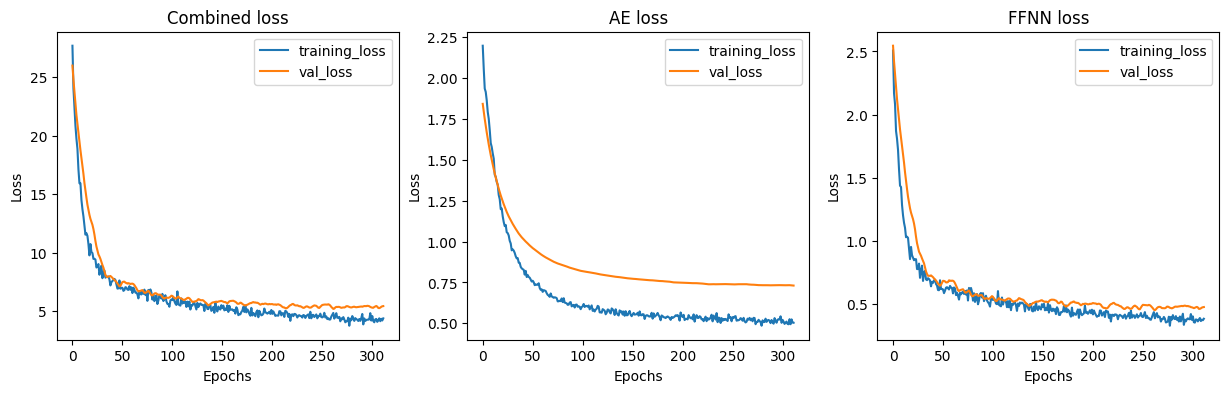

In [12]:
fig,ax = plt.subplots(1,3, figsize = (15,4))
ax[0].plot(history.history['loss'], label='training_loss')
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Combined loss')

ax[1].plot(history.history['dense_1_mean_squared_error'], label='training_loss')
ax[1].plot(history.history['val_dense_1_mean_squared_error'], label='val_loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('AE loss')

ax[2].plot(history.history['dense_3_mean_absolute_error'], label='training_loss')
ax[2].plot(history.history['val_dense_3_mean_absolute_error'], label='val_loss')
ax[2].legend()
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].set_title('FFNN loss')

plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


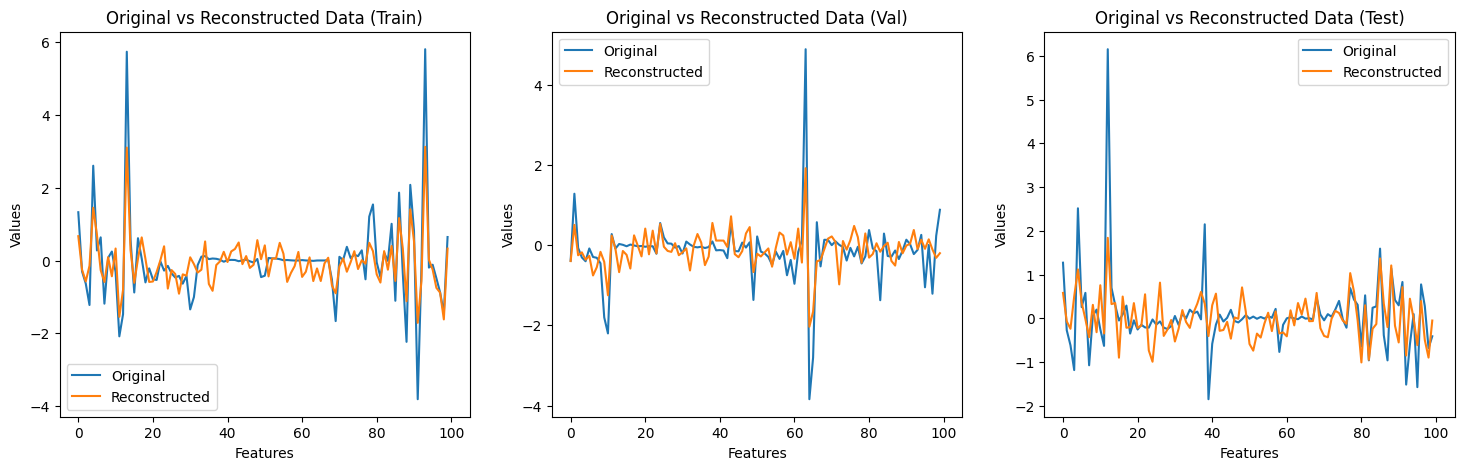

In [13]:
reconstructed_X_train = autoencoder.predict(X_train)
reconstructed_X_val = autoencoder.predict(X_val)
reconstructed_X_test = autoencoder.predict(X_test)

sample_idx_train = X_train[0]
sample_idx_val = X_val[0]
sample_idx_test = X_test[0]

fig, ax = plt.subplots(1,3, figsize = (18,5))

ax[0].plot(X_train[0], label = 'Original')
ax[1].plot(X_val[0], label = 'Original')
ax[2].plot(X_test[0], label = 'Original')

ax[0].plot(reconstructed_X_train[0], label = 'Reconstructed')
ax[1].plot(reconstructed_X_val[0], label = 'Reconstructed')
ax[2].plot(reconstructed_X_test[0], label = 'Reconstructed')

ax[0].set_xlabel('Features')
ax[0].set_ylabel('Values')

ax[1].set_xlabel('Features')
ax[1].set_ylabel('Values')

ax[2].set_xlabel('Features')
ax[2].set_ylabel('Values')

ax[0].set_title('Original vs Reconstructed Data (Train)')
ax[1].set_title('Original vs Reconstructed Data (Val)')
ax[2].set_title('Original vs Reconstructed Data (Test)')

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].set_xlim([-5, X.shape[1]+5])
ax[1].set_xlim([-5, X.shape[1]+5])
ax[2].set_xlim([-5, X.shape[1]+5])

plt.show()

In [14]:
pred_train = combined_model.predict(X_train)#, [X_train, y_train])
pred_val = combined_model.predict(X_val)#, [X_val, y_val])
pred_test = combined_model.predict(X_test)#, [X_test, y_test])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


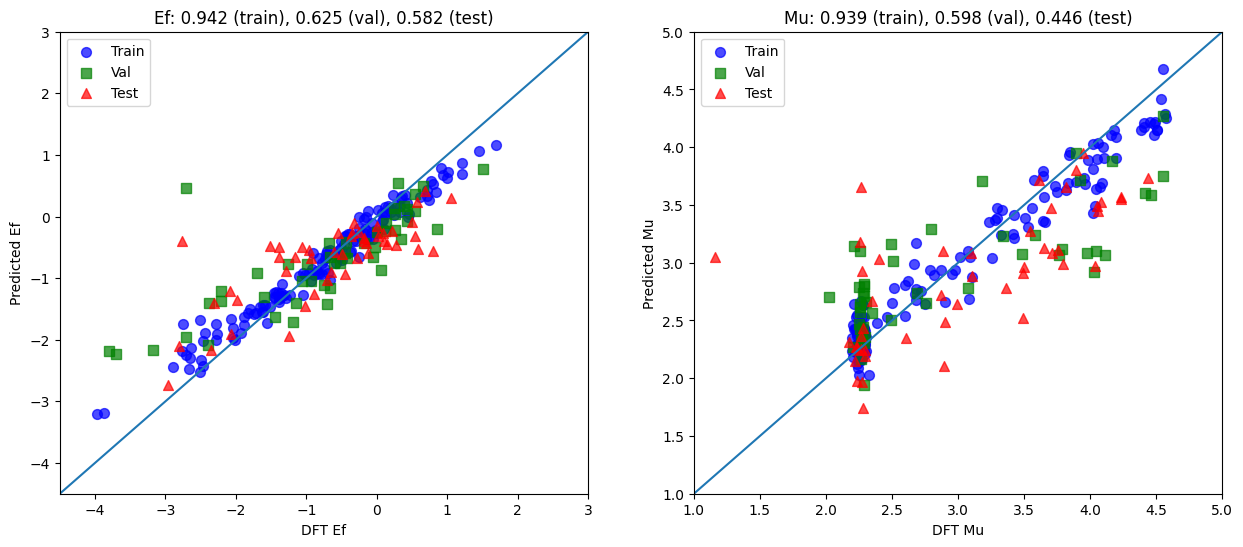

In [17]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (15,6))
ax1.scatter(y_train['Ef_per_cell'], pred_train[1][:,0], color = 'blue', alpha = 0.7, s = 50, marker = 'o', label = 'Train')
ax1.scatter(y_val['Ef_per_cell'], pred_val[1][:,0], color = 'green', alpha = 0.7, s = 50, marker = 's', label = 'Val')
ax1.scatter(y_test['Ef_per_cell'], pred_test[1][:,0], color = 'red', alpha = 0.7, s = 50, marker = '^', label = 'Test')
ax1.plot([-4.5, 3], [-4.5, 3])

ax2.scatter(y_train['Mu_per_cell'], pred_train[1][:,1], color = 'blue', alpha = 0.7, s = 50, marker = 'o', label = 'Train')
ax2.scatter(y_val['Mu_per_cell'], pred_val[1][:,1], color = 'green', alpha = 0.7, s = 50, marker = 's', label = 'Val')
ax2.scatter(y_test['Mu_per_cell'], pred_test[1][:,1], color = 'red', alpha = 0.7, s = 50, marker = '^', label = 'Test')
ax2.plot([0, 5], [0, 5])

ax1.set_title('Ef: {:.3f} (train), {:.3f} (val), {:.3f} (test)'.format(metrics.r2_score(y_train['Ef_per_cell'], pred_train[1][:,0]),metrics.r2_score(y_val['Ef_per_cell'], pred_val[1][:,0]),metrics.r2_score(y_test['Ef_per_cell'], pred_test[1][:,0])))
ax2.set_title('Mu: {:.3f} (train), {:.3f} (val), {:.3f} (test)'.format(metrics.r2_score(y_train['Mu_per_cell'], pred_train[1][:,1]),metrics.r2_score(y_val['Mu_per_cell'], pred_val[1][:,1]),metrics.r2_score(y_test['Mu_per_cell'], pred_test[1][:,1])))

ax1.set_xlabel('DFT Ef')
ax1.set_ylabel('Predicted Ef')

ax2.set_xlabel('DFT Mu')
ax2.set_ylabel('Predicted Mu')

ax1.set_xlim([-4.5, 3])
ax1.set_ylim([-4.5, 3])

ax2.set_xlim([1, 5])
ax2.set_ylim([1, 5])

ax1.legend()
ax2.legend()

plt.show()

In [18]:
r2_train_ef = metrics.r2_score(y_train['Ef_per_cell'], pred_train[1][:,0])
r2_train_mu = metrics.r2_score(y_train['Mu_per_cell'], pred_train[1][:,1])

r2_val_ef = metrics.r2_score(y_val['Ef_per_cell'], pred_val[1][:,0])
r2_val_mu = metrics.r2_score(y_val['Mu_per_cell'], pred_val[1][:,1])

r2_test_ef = metrics.r2_score(y_test['Ef_per_cell'], pred_test[1][:,0])
r2_test_mu = metrics.r2_score(y_test['Mu_per_cell'], pred_test[1][:,1])

mae_train_ef = metrics.mean_absolute_error(y_train['Ef_per_cell'], pred_train[1][:,0])
mae_train_mu = metrics.mean_absolute_error(y_train['Mu_per_cell'], pred_train[1][:,1])

mae_val_ef = metrics.mean_absolute_error(y_val['Ef_per_cell'], pred_val[1][:,0])
mae_val_mu = metrics.mean_absolute_error(y_val['Mu_per_cell'], pred_val[1][:,1])

mae_test_ef = metrics.mean_absolute_error(y_test['Ef_per_cell'], pred_test[1][:,0])
mae_test_mu = metrics.mean_absolute_error(y_test['Mu_per_cell'], pred_test[1][:,1])

In [19]:
width = 10
print(f'{"Properties":>{width+1}} {"R2(Train)":>{width+1}} {"R2(Val)":>{width-1}} {"R2(Test)":>{width}} {"MAE(Train)":>{width+2}} {"MAE(Val)":>{width}} {"MAE(Test)":>{width}}')
print('='*80)
print(f'{"Ef":>{width}} {r2_train_ef:>{width}.3f} {r2_val_ef:>{width}.3f} {r2_test_ef:>{width}.3f} {mae_train_ef:>{width}.3f} {mae_val_ef:>{width}.3f} {mae_test_ef:>{width}.3f}')
print(f'{"Mu":>{width}} {r2_train_mu:>{width}.3f} {r2_val_mu:>{width}.3f} {r2_test_mu:>{width}.3f} {mae_train_mu:>{width}.3f} {mae_val_mu:>{width}.3f} {mae_test_mu:>{width}.3f}')

 Properties   R2(Train)   R2(Val)   R2(Test)   MAE(Train)   MAE(Val)  MAE(Test)
        Ef      0.942      0.625      0.582      0.198      0.523      0.502
        Mu      0.939      0.598      0.446      0.159      0.418      0.438


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


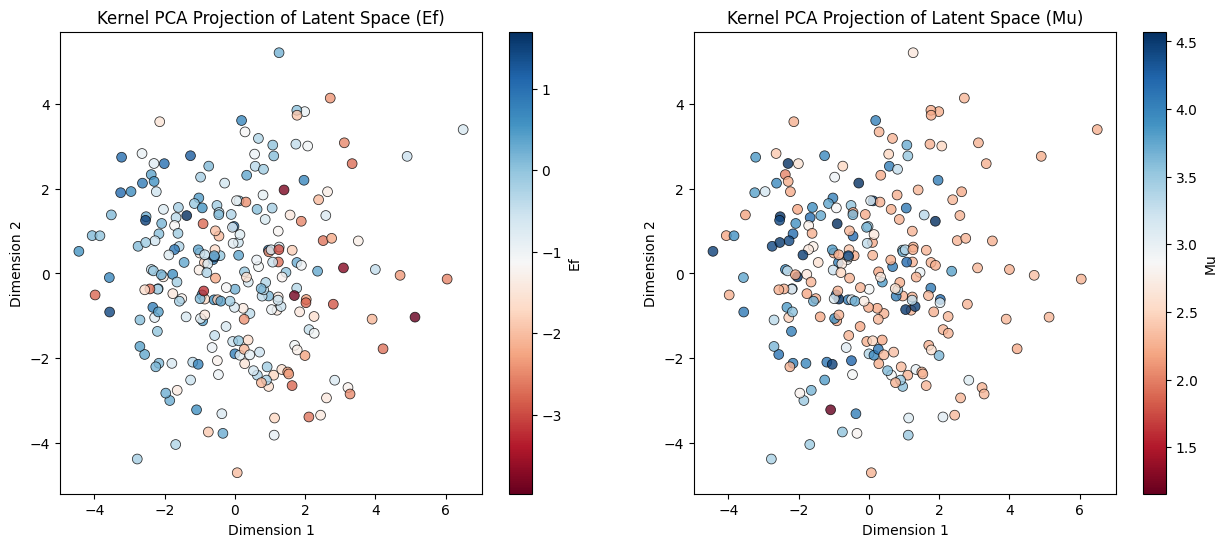

In [21]:
# Extract latent representations
encoder_model = Model(inputs = encoder_input, outputs = encoder_output)
latent_X = encoder_model.predict(X)

# Apply Kernel PCA
kpca = KernelPCA(n_components=2, kernel='linear', gamma=None, fit_inverse_transform=True, alpha=1.0, n_jobs=-1)
kpca_embeddings = kpca.fit_transform(latent_X)

# Create a DataFrame for Seaborn
kpca_df = pd.DataFrame(data={'Dimension 1': kpca_embeddings[:, 0],
                             'Dimension 2': kpca_embeddings[:, 1],
                             'Ef': y['Ef_per_cell'],
                             'Mu': y['Mu_per_cell']})

# Visualize the projected latent space using Seaborn
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
scatter_ef = sns.scatterplot(ax=ax[0], data=kpca_df, x='Dimension 1', y='Dimension 2', hue='Ef', palette='RdBu', s=50, alpha=0.8, edgecolor='k', legend=False)
scatter_mu = sns.scatterplot(ax=ax[1], data=kpca_df, x='Dimension 1', y='Dimension 2', hue='Mu', palette='RdBu', s=50, alpha=0.8, edgecolor='k', legend=False)

norm_ef = Normalize(vmin=kpca_df['Ef'].min(), vmax=kpca_df['Ef'].max())
norm_mu = Normalize(vmin=kpca_df['Mu'].min(), vmax=kpca_df['Mu'].max())

sm_ef = plt.cm.ScalarMappable(cmap='RdBu', norm=norm_ef)
sm_mu = plt.cm.ScalarMappable(cmap='RdBu', norm=norm_mu)

sm_ef.set_array([])
sm_mu.set_array([])

cbar_ef = fig.colorbar(sm_ef, ax=ax[0])
cbar_mu = fig.colorbar(sm_mu, ax=ax[1])

cbar_ef.set_label('Ef')
cbar_mu.set_label('Mu')

ax[0].set_title('Kernel PCA Projection of Latent Space (Ef)')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')

ax[1].set_title('Kernel PCA Projection of Latent Space (Mu)')
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')

plt.show()

In [22]:
# !pip install optuna
# !pip install nbformat
import optuna
import optuna.importance
from optuna.visualization import plot_pareto_front, plot_param_importances, plot_parallel_coordinate, plot_intermediate_values

C:\Users\Romakanta\Desktop\vENVs\vSOAP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
def optuna_HP(trial):
    
    # Hyperparameters to tune
    dropout_encoder = trial.suggest_float('dropout_encoder', 0.0, 0.5)
    dropout_ffnn = trial.suggest_float('dropout_ffnn', 0.0, 0.5)
#    reg_L1_encoder = trial.suggest_float('reg_L1_encocder', 1e-5, 0.5)
#    reg_L1_ffnn = trial.suggest_float('reg_L1_ffnn', 1e-5, 0.5)
#    reg_L2_encoder = trial.suggest_float('reg_L2_encocder', 1e-5, 0.5)
#    reg_L2_ffnn = trial.suggest_float('reg_L2_ffnn', 1e-5, 0.5)
    learning_rate = trial.suggest_float('learniing_rate', 1e-4, 1e-2)
    
    # Tune encoder layer dimensions
    input_dim = X_train.shape[1]
#    layer1_dim_encoder = trial.suggest_int('layer1_dim_encoder', 50, input_dim)
    latent_dim_encoder = trial.suggest_int('latent_dim_encoder', 50, input_dim)
    
    # Tune FFNN layer dimensions
    layer1_dim_ffnn = trial.suggest_int('layer1_dim_ffnn', 20, latent_dim_encoder)
#    layer2_dim_ffnn = trial.suggest_int('layer2_dim_ffnn', 5, layer1_dim_ffnn)
    
    # Tune activation function
    activation_funcn = trial.suggest_categorical('activation_funcn', ['elu', 'relu', 'selu'])
    
    # Optimizer
    optimizer = Adam(learning_rate=learning_rate)
    
    # Model architecture
    encoder_input = keras.Input(shape = (input_dim,))
    encoder = Dropout(dropout_encoder)(encoder_input)
#    encoder = Dense(layer1_dim_encoder, activation=activation_funcn, kernel_regularizer=L1(reg_L1_encoder))(encoder)
#    encoder = Dropout(dropout_encoder)(encoder_input)
    encoder_output = Dense(latent_dim_encoder, activation=activation_funcn)(encoder)
    
    decoder_output = Dense(input_dim, activation='linear')(encoder_output)


    # autoencoder
    autoencoder = Model(inputs = encoder_input, outputs = decoder_output)
    autoencoder.compile(optimizer = Adam(learning_rate = learning_rate), loss=MeanSquaredError())    
    
    # FFNN
    ffnn_MBT_input = Dense(layer1_dim_ffnn, activation = activation_funcn)(encoder_output)
    ffnn_MBT = Dropout(dropout_ffnn)(ffnn_MBT_input)
#     ffnn_MBT = Dense(layer2_dim_ffnn, activation = activation_funcn)(ffnn_MBT)
#     ffnn_MBT = Dropout(dropout_ffnn)(ffnn_MBT)
    ffnn_MBT_output = Dense(2, activation = 'linear')(ffnn_MBT)

    # Combined model
    combined_output = [decoder_output, ffnn_MBT_output]
    combined_model = Model(inputs=encoder_input, outputs=combined_output)
    combined_model.compile(optimizer=optimizer, loss=[MeanSquaredError(), MeanAbsoluteError()], 
                           loss_weights=[1, 10], metrics = [MeanSquaredError, MeanAbsoluteError]) 

    # Training
    history = combined_model.fit(X_train, [X_train, y_train],
                                 validation_data=(X_val, [X_val, y_val]),
                                 epochs=500, batch_size=32, callbacks=[EarlyStopping(patience=100, min_delta=0.001)], verbose=0)


    pred_val = combined_model.predict(X_val)
    r2_score_ef = metrics.r2_score(y_val['Ef_per_cell'], pred_val[1][:,0])
    r2_score_mu = metrics.r2_score(y_val['Mu_per_cell'], pred_val[1][:,1])
    
    return r2_score_ef,r2_score_mu

In [29]:
# Create and optimize the study
# study = optuna.create_study(direction = 'maximize')
study = optuna.create_study(directions = ['maximize','maximize'])
study.optimize(optuna_HP, n_trials=200)

[I 2024-06-09 21:53:28,893] A new study created in memory with name: no-name-9d4a4781-c623-407c-80c7-21e19af09385


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002CF12E6B8B0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2024-06-09 21:53:41,040] Trial 0 finished with values: [0.6674675550175814, 0.7105049895295237] and parameters: {'dropout_encoder': 0.14283681542551813, 'dropout_ffnn': 0.1740759762797438, 'learniing_rate': 0.006788026172289672, 'latent_dim_encoder': 56, 'layer1_dim_ffnn': 46, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 21:53:54,090] Trial 1 finished with values: [0.6410439366860872, 0.7622754021967193] and parameters: {'dropout_encoder': 0.14802211889278905, 'dropout_ffnn': 0.13765398915565347, 'learniing_rate': 0.00648693405682811, 'latent_dim_encoder': 67, 'layer1_dim_ffnn': 49, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 21:54:22,984] Trial 2 finished with values: [0.5109190854058646, 0.7574974978778808] and parameters: {'dropout_encoder': 0.4836297784511812, 'dropout_ffnn': 0.009846309716846857, 'learniing_rate': 0.006646440582375489, 'latent_dim_encoder': 55, 'layer1_dim_ffnn': 27, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[I 2024-06-09 21:54:54,647] Trial 3 finished with values: [0.6040902835898898, 0.631892661494115] and parameters: {'dropout_encoder': 0.11613515031230232, 'dropout_ffnn': 0.13500054672191247, 'learniing_rate': 0.0008678672088153544, 'latent_dim_encoder': 57, 'layer1_dim_ffnn': 26, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 21:55:16,479] Trial 4 finished with values: [0.568895696040296, 0.6220488229378826] and parameters: {'dropout_encoder': 0.1718267074282125, 'dropout_ffnn': 0.10493490291418517, 'learniing_rate': 0.009393541942249567, 'latent_dim_encoder': 64, 'layer1_dim_ffnn': 27, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 21:55:32,946] Trial 5 finished with values: [0.6901310383277128, 0.6801337643604356] and parameters: {'dropout_encoder': 0.1538342431515043, 'dropout_ffnn': 0.13904621771209336, 'learniing_rate': 0.004085879987831423, 'latent_dim_encoder': 98, 'layer1_dim_ffnn': 52, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 21:56:04,597] Trial 6 finished with values: [0.5085491992566054, 0.017030365612156317] and parameters: {'dropout_encoder': 0.3713514360831104, 'dropout_ffnn': 0.1582032196126621, 'learniing_rate': 0.00011702353175016382, 'latent_dim_encoder': 60, 'layer1_dim_ffnn': 40, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 21:56:22,684] Trial 7 finished with values: [0.4729816670289094, 0.5752283920907033] and parameters: {'dropout_encoder': 0.24301243411798196, 'dropout_ffnn': 0.49956979002779, 'learniing_rate': 0.00882856556296829, 'latent_dim_encoder': 64, 'layer1_dim_ffnn': 44, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 21:56:48,350] Trial 8 finished with values: [0.5249846456356455, 0.6258673963137396] and parameters: {'dropout_encoder': 0.45159401202430977, 'dropout_ffnn': 0.22003619472245417, 'learniing_rate': 0.00806466425788491, 'latent_dim_encoder': 60, 'layer1_dim_ffnn': 23, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 21:57:08,852] Trial 9 finished with values: [0.6397168916731419, 0.6568309459913791] and parameters: {'dropout_encoder': 0.4433856896917762, 'dropout_ffnn': 0.40246470375374377, 'learniing_rate': 0.003530530756237534, 'latent_dim_encoder': 53, 'layer1_dim_ffnn': 36, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 21:57:24,822] Trial 10 finished with values: [0.6493335634364961, 0.8081127520371064] and parameters: {'dropout_encoder': 0.300479181469132, 'dropout_ffnn': 0.15868354024718517, 'learniing_rate': 0.007114809452439151, 'latent_dim_encoder': 83, 'layer1_dim_ffnn': 23, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 21:57:45,793] Trial 11 finished with values: [0.5852471859648166, 0.6865143171535757] and parameters: {'dropout_encoder': 0.44072288511843905, 'dropout_ffnn': 0.4141590377443784, 'learniing_rate': 0.006150335495388537, 'latent_dim_encoder': 93, 'layer1_dim_ffnn': 73, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 21:58:07,752] Trial 12 finished with values: [0.5423392791264201, 0.5670640550687547] and parameters: {'dropout_encoder': 0.2783131750659674, 'dropout_ffnn': 0.215632130954729, 'learniing_rate': 0.001965187575902293, 'latent_dim_encoder': 62, 'layer1_dim_ffnn': 22, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 21:58:39,242] Trial 13 finished with values: [0.6441987889277174, -1.0376349665464062] and parameters: {'dropout_encoder': 0.022451160998299913, 'dropout_ffnn': 0.31623606538258603, 'learniing_rate': 0.00018812551303433044, 'latent_dim_encoder': 63, 'layer1_dim_ffnn': 50, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 21:59:04,006] Trial 14 finished with values: [0.6632734142927371, 0.6183382356894205] and parameters: {'dropout_encoder': 0.021579465870181003, 'dropout_ffnn': 0.26064147179815644, 'learniing_rate': 0.007048739346929014, 'latent_dim_encoder': 51, 'layer1_dim_ffnn': 38, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-06-09 21:59:19,030] Trial 15 finished with values: [0.5514898134452869, 0.6580503450079316] and parameters: {'dropout_encoder': 0.040104053564479214, 'dropout_ffnn': 0.39787708731210975, 'learniing_rate': 0.00922002934459373, 'latent_dim_encoder': 91, 'layer1_dim_ffnn': 36, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 21:59:48,768] Trial 16 finished with values: [0.6956195811583621, 0.7621858684910097] and parameters: {'dropout_encoder': 0.009575749535908618, 'dropout_ffnn': 0.12403689960979891, 'learniing_rate': 0.0030223748699792262, 'latent_dim_encoder': 57, 'layer1_dim_ffnn': 22, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:00:04,725] Trial 17 finished with values: [0.7021826002435563, 0.6222145415167271] and parameters: {'dropout_encoder': 0.32642814711292084, 'dropout_ffnn': 0.41566578585636504, 'learniing_rate': 0.008571483224040157, 'latent_dim_encoder': 94, 'layer1_dim_ffnn': 85, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:00:26,178] Trial 18 finished with values: [0.7083093069484956, 0.7015306234557378] and parameters: {'dropout_encoder': 0.3489263591337954, 'dropout_ffnn': 0.4775687157699333, 'learniing_rate': 0.0026061869291040254, 'latent_dim_encoder': 50, 'layer1_dim_ffnn': 37, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 22:00:42,101] Trial 19 finished with values: [0.7525724974432368, 0.7719246618398177] and parameters: {'dropout_encoder': 0.06793699012230481, 'dropout_ffnn': 0.19304367476767165, 'learniing_rate': 0.003541814225708617, 'latent_dim_encoder': 53, 'layer1_dim_ffnn': 39, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:00:53,861] Trial 20 finished with values: [0.6198955338532359, 0.6644324110059627] and parameters: {'dropout_encoder': 0.44072926437247356, 'dropout_ffnn': 0.27284428670348004, 'learniing_rate': 0.006165985873084166, 'latent_dim_encoder': 77, 'layer1_dim_ffnn': 74, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[I 2024-06-09 22:01:11,011] Trial 21 finished with values: [0.7658365372446478, 0.800443403885111] and parameters: {'dropout_encoder': 0.06034114510265737, 'dropout_ffnn': 0.34798604388359433, 'learniing_rate': 0.004811258357002826, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 40, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[I 2024-06-09 22:01:42,782] Trial 22 finished with values: [0.5414730043730687, 0.24187702046498005] and parameters: {'dropout_encoder': 0.18274147932465745, 'dropout_ffnn': 0.4753116926503191, 'learniing_rate': 0.00010318993876023946, 'latent_dim_encoder': 81, 'layer1_dim_ffnn': 81, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:02:03,846] Trial 23 finished with values: [0.6733082112742479, 0.6618445581384023] and parameters: {'dropout_encoder': 0.3633431359110217, 'dropout_ffnn': 0.38337622570673136, 'learniing_rate': 0.0013225265912647525, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 24, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:02:26,327] Trial 24 finished with values: [0.6009521048381342, 0.8154061325716234] and parameters: {'dropout_encoder': 0.2953274414485992, 'dropout_ffnn': 0.1663108101997257, 'learniing_rate': 0.006511957619720026, 'latent_dim_encoder': 57, 'layer1_dim_ffnn': 24, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:02:38,709] Trial 25 finished with values: [0.7038963380666706, 0.7095970017032259] and parameters: {'dropout_encoder': 0.1816177764195545, 'dropout_ffnn': 0.3667809261913964, 'learniing_rate': 0.0029966338152856743, 'latent_dim_encoder': 100, 'layer1_dim_ffnn': 85, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:02:53,039] Trial 26 finished with values: [0.6105307509778872, 0.6453858655018458] and parameters: {'dropout_encoder': 0.20693552596560794, 'dropout_ffnn': 0.11151499199314796, 'learniing_rate': 0.0012749133746271391, 'latent_dim_encoder': 94, 'layer1_dim_ffnn': 73, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:03:24,242] Trial 27 finished with values: [0.5982936344102048, 0.5329532007874488] and parameters: {'dropout_encoder': 0.4578457607059155, 'dropout_ffnn': 0.016293572208951224, 'learniing_rate': 0.0003000432407165404, 'latent_dim_encoder': 58, 'layer1_dim_ffnn': 35, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:03:46,355] Trial 28 finished with values: [0.5652181890956597, 0.7368725775394511] and parameters: {'dropout_encoder': 0.17571076841162026, 'dropout_ffnn': 0.22283219479081728, 'learniing_rate': 0.005548698091178888, 'latent_dim_encoder': 53, 'layer1_dim_ffnn': 41, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:03:58,436] Trial 29 finished with values: [0.6501824639579596, 0.6949984832851055] and parameters: {'dropout_encoder': 0.17046376553383108, 'dropout_ffnn': 0.02207833825462041, 'learniing_rate': 0.0033865779365912616, 'latent_dim_encoder': 83, 'layer1_dim_ffnn': 65, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-06-09 22:04:27,163] Trial 30 finished with values: [0.5457281514807892, 0.7597862217562296] and parameters: {'dropout_encoder': 0.2854158036878105, 'dropout_ffnn': 0.2501431685346875, 'learniing_rate': 0.004728733779061427, 'latent_dim_encoder': 62, 'layer1_dim_ffnn': 37, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-06-09 22:04:40,738] Trial 31 finished with values: [0.5727111508480577, 0.6476775575151643] and parameters: {'dropout_encoder': 0.3920818288620073, 'dropout_ffnn': 0.1441593804065754, 'learniing_rate': 0.00924894350806414, 'latent_dim_encoder': 52, 'layer1_dim_ffnn': 40, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:05:11,709] Trial 32 finished with values: [0.5197168451754635, 0.6409280067225407] and parameters: {'dropout_encoder': 0.31663698129666046, 'dropout_ffnn': 0.04868383927611858, 'learniing_rate': 0.0014041466131012573, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 40, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:05:25,680] Trial 33 finished with values: [0.46627254399882223, 0.6707280259517505] and parameters: {'dropout_encoder': 0.4913525747678743, 'dropout_ffnn': 0.011000963176038103, 'learniing_rate': 0.004801472095486638, 'latent_dim_encoder': 92, 'layer1_dim_ffnn': 52, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2024-06-09 22:05:45,889] Trial 34 finished with values: [0.5788138284523326, 0.7485825718690147] and parameters: {'dropout_encoder': 0.31895902000342585, 'dropout_ffnn': 0.2687522592225349, 'learniing_rate': 0.005495591762716535, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 30, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 22:06:03,590] Trial 35 finished with values: [0.611231613797063, 0.734872380221937] and parameters: {'dropout_encoder': 0.37899417413319264, 'dropout_ffnn': 0.09842153537441933, 'learniing_rate': 0.00253557434340393, 'latent_dim_encoder': 69, 'layer1_dim_ffnn': 42, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2024-06-09 22:06:24,212] Trial 36 finished with values: [0.558541257612694, 0.686969476983353] and parameters: {'dropout_encoder': 0.4798650128867098, 'dropout_ffnn': 0.1773917406505202, 'learniing_rate': 0.0029684551626239356, 'latent_dim_encoder': 61, 'layer1_dim_ffnn': 35, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:06:44,119] Trial 37 finished with values: [0.6710859694422797, 0.6657750391807576] and parameters: {'dropout_encoder': 0.33982157541168123, 'dropout_ffnn': 0.23931242507193323, 'learniing_rate': 0.0023003237926771387, 'latent_dim_encoder': 92, 'layer1_dim_ffnn': 87, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:06:58,865] Trial 38 finished with values: [0.6526507653351749, 0.794510678708095] and parameters: {'dropout_encoder': 0.11514916782473983, 'dropout_ffnn': 0.07399694678584218, 'learniing_rate': 0.005780178983456641, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 54, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 22:07:22,975] Trial 39 finished with values: [0.6074101817038353, 0.6751789332579752] and parameters: {'dropout_encoder': 0.4841021380488769, 'dropout_ffnn': 0.19581932049109946, 'learniing_rate': 0.0017409137086456519, 'latent_dim_encoder': 60, 'layer1_dim_ffnn': 30, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2024-06-09 22:07:45,626] Trial 40 finished with values: [0.7477104222596171, 0.6867091785557313] and parameters: {'dropout_encoder': 0.07720078433189898, 'dropout_ffnn': 0.13306042186878148, 'learniing_rate': 0.0013466770368196685, 'latent_dim_encoder': 99, 'layer1_dim_ffnn': 81, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:08:03,411] Trial 41 finished with values: [0.6134082096529845, 0.7363201857224637] and parameters: {'dropout_encoder': 0.2512192543337017, 'dropout_ffnn': 0.02382838933929976, 'learniing_rate': 0.0021001687694158933, 'latent_dim_encoder': 97, 'layer1_dim_ffnn': 53, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:08:34,808] Trial 42 finished with values: [0.7737425260573771, 0.680480815744992] and parameters: {'dropout_encoder': 0.013679931684459523, 'dropout_ffnn': 0.3510012676657874, 'learniing_rate': 0.0012160277105289425, 'latent_dim_encoder': 75, 'layer1_dim_ffnn': 42, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-06-09 22:08:48,991] Trial 43 finished with values: [0.6389802727651013, 0.6399249502423852] and parameters: {'dropout_encoder': 0.46509811410625307, 'dropout_ffnn': 0.3222357555211296, 'learniing_rate': 0.004165987156450191, 'latent_dim_encoder': 75, 'layer1_dim_ffnn': 42, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:09:15,517] Trial 44 finished with values: [0.6910897618323929, 0.6895898508799185] and parameters: {'dropout_encoder': 0.20141152718429245, 'dropout_ffnn': 0.4647682452441324, 'learniing_rate': 0.0015276047181352816, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 41, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:09:32,920] Trial 45 finished with values: [0.6783106947716205, 0.7965577016808794] and parameters: {'dropout_encoder': 0.11686799718328683, 'dropout_ffnn': 0.3510489344257745, 'learniing_rate': 0.00624006136277896, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 43, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 22:10:04,723] Trial 46 finished with values: [0.6430463199814815, 0.7329460345670461] and parameters: {'dropout_encoder': 0.1654562086616247, 'dropout_ffnn': 0.07140421828830357, 'learniing_rate': 0.0005524702257860123, 'latent_dim_encoder': 82, 'layer1_dim_ffnn': 46, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:10:16,834] Trial 47 finished with values: [0.7508561982085642, 0.7614888271361333] and parameters: {'dropout_encoder': 0.09055716669583952, 'dropout_ffnn': 0.22773754579994698, 'learniing_rate': 0.005023306866711395, 'latent_dim_encoder': 79, 'layer1_dim_ffnn': 35, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 22:10:38,431] Trial 48 finished with values: [0.6520419458136115, 0.7517061449814025] and parameters: {'dropout_encoder': 0.3985583177722337, 'dropout_ffnn': 0.29317646338968556, 'learniing_rate': 0.007236975570881462, 'latent_dim_encoder': 67, 'layer1_dim_ffnn': 30, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:11:09,990] Trial 49 finished with values: [0.6230740751856465, 0.6314363910774847] and parameters: {'dropout_encoder': 0.4461339411962768, 'dropout_ffnn': 0.43620072101511015, 'learniing_rate': 0.0004587301045609497, 'latent_dim_encoder': 98, 'layer1_dim_ffnn': 66, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:11:41,357] Trial 50 finished with values: [0.7531400079423994, 0.6807994266370592] and parameters: {'dropout_encoder': 0.06034114510265737, 'dropout_ffnn': 0.07140421828830357, 'learniing_rate': 0.0005524702257860123, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 60, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:12:03,681] Trial 51 finished with values: [0.7246444389887865, 0.8153382788636733] and parameters: {'dropout_encoder': 0.11686799718328683, 'dropout_ffnn': 0.3510489344257745, 'learniing_rate': 0.003882747573938467, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 62, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:12:20,483] Trial 52 finished with values: [0.6254899686828668, 0.7109771553244789] and parameters: {'dropout_encoder': 0.33982157541168123, 'dropout_ffnn': 0.38337622570673136, 'learniing_rate': 0.0023003237926771387, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 67, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[I 2024-06-09 22:12:33,368] Trial 53 finished with values: [0.6096560701948095, 0.5703195026736905] and parameters: {'dropout_encoder': 0.37899417413319264, 'dropout_ffnn': 0.09842153537441933, 'learniing_rate': 0.00253557434340393, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 61, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:12:58,201] Trial 54 finished with values: [0.6981235940076815, 0.7411595659492753] and parameters: {'dropout_encoder': 0.20141152718429245, 'dropout_ffnn': 0.3222357555211296, 'learniing_rate': 0.0015276047181352816, 'latent_dim_encoder': 69, 'layer1_dim_ffnn': 27, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2024-06-09 22:13:29,016] Trial 55 finished with values: [0.6944368504705551, 0.7215317544220312] and parameters: {'dropout_encoder': 0.20141152718429245, 'dropout_ffnn': 0.41566578585636504, 'learniing_rate': 0.0015276047181352816, 'latent_dim_encoder': 94, 'layer1_dim_ffnn': 62, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-06-09 22:13:54,114] Trial 56 finished with values: [0.5686114603728729, 0.8015365531488374] and parameters: {'dropout_encoder': 0.4798650128867098, 'dropout_ffnn': 0.1773917406505202, 'learniing_rate': 0.00253557434340393, 'latent_dim_encoder': 69, 'layer1_dim_ffnn': 67, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:14:16,236] Trial 57 finished with values: [0.619595097760183, 0.6945483764455633] and parameters: {'dropout_encoder': 0.25280846230887394, 'dropout_ffnn': 0.015835443966653984, 'learniing_rate': 0.0030223748699792262, 'latent_dim_encoder': 92, 'layer1_dim_ffnn': 72, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


[I 2024-06-09 22:14:32,795] Trial 58 finished with values: [0.4569706995194204, 0.6980602124095389] and parameters: {'dropout_encoder': 0.4836297784511812, 'dropout_ffnn': 0.3544262510661279, 'learniing_rate': 0.006646440582375489, 'latent_dim_encoder': 93, 'layer1_dim_ffnn': 42, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-06-09 22:15:00,506] Trial 59 finished with values: [0.5809509911115402, 0.7415394608988889] and parameters: {'dropout_encoder': 0.37899417413319264, 'dropout_ffnn': 0.10088049792679049, 'learniing_rate': 0.00624006136277896, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 64, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:15:15,755] Trial 60 finished with values: [0.581889558177672, 0.7150451001069587] and parameters: {'dropout_encoder': 0.44072288511843905, 'dropout_ffnn': 0.002257644848256246, 'learniing_rate': 0.006150335495388537, 'latent_dim_encoder': 93, 'layer1_dim_ffnn': 62, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:15:30,792] Trial 61 finished with values: [0.5970460939195467, 0.7285677682683303] and parameters: {'dropout_encoder': 0.4578457607059155, 'dropout_ffnn': 0.016293572208951224, 'learniing_rate': 0.0033865779365912616, 'latent_dim_encoder': 82, 'layer1_dim_ffnn': 81, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:15:56,610] Trial 62 finished with values: [0.6590539565509252, 0.5986562010344296] and parameters: {'dropout_encoder': 0.3985583177722337, 'dropout_ffnn': 0.19581932049109946, 'learniing_rate': 0.0017409137086456519, 'latent_dim_encoder': 60, 'layer1_dim_ffnn': 21, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:16:27,999] Trial 63 finished with values: [0.7984772521271503, 0.8044238061587123] and parameters: {'dropout_encoder': 0.07720078433189898, 'dropout_ffnn': 0.38337622570673136, 'learniing_rate': 0.0013466770368196685, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 43, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:16:48,373] Trial 64 finished with values: [0.5976544720294681, 0.652980401843163] and parameters: {'dropout_encoder': 0.459192052967946, 'dropout_ffnn': 0.3667809261913964, 'learniing_rate': 0.0029966338152856743, 'latent_dim_encoder': 75, 'layer1_dim_ffnn': 20, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:17:11,079] Trial 65 finished with values: [0.628055094749425, 0.7010816265358277] and parameters: {'dropout_encoder': 0.31895902000342585, 'dropout_ffnn': 0.29317646338968556, 'learniing_rate': 0.0016396379877015093, 'latent_dim_encoder': 67, 'layer1_dim_ffnn': 41, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:17:40,123] Trial 66 finished with values: [0.704321836185394, 0.7358291534226737] and parameters: {'dropout_encoder': 0.009575749535908618, 'dropout_ffnn': 0.1816506956887139, 'learniing_rate': 0.0030223748699792262, 'latent_dim_encoder': 57, 'layer1_dim_ffnn': 46, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[I 2024-06-09 22:17:58,687] Trial 67 finished with values: [0.6887583313797982, 0.7400041691378576] and parameters: {'dropout_encoder': 0.1538342431515043, 'dropout_ffnn': 0.13904621771209336, 'learniing_rate': 0.005023306866711395, 'latent_dim_encoder': 98, 'layer1_dim_ffnn': 28, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:18:22,211] Trial 68 finished with values: [0.5751763990329417, 0.7134045751669602] and parameters: {'dropout_encoder': 0.17571076841162026, 'dropout_ffnn': 0.19454291098218435, 'learniing_rate': 0.005548698091178888, 'latent_dim_encoder': 53, 'layer1_dim_ffnn': 34, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:18:47,776] Trial 69 finished with values: [0.7513238211194864, 0.7719619864839977] and parameters: {'dropout_encoder': 0.054583824165562955, 'dropout_ffnn': 0.41273578832463886, 'learniing_rate': 0.004811258357002826, 'latent_dim_encoder': 83, 'layer1_dim_ffnn': 82, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 22:19:14,503] Trial 70 finished with values: [0.7204335286583743, 0.7300870673368154] and parameters: {'dropout_encoder': 0.14802211889278905, 'dropout_ffnn': 0.4647682452441324, 'learniing_rate': 0.0015276047181352816, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 74, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 22:19:37,126] Trial 71 finished with values: [0.7562105575411235, 0.7824491161279988] and parameters: {'dropout_encoder': 0.07720078433189898, 'dropout_ffnn': 0.13306042186878148, 'learniing_rate': 0.0013466770368196685, 'latent_dim_encoder': 99, 'layer1_dim_ffnn': 50, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-06-09 22:19:53,671] Trial 72 finished with values: [0.48419757370307204, 0.6162993405512365] and parameters: {'dropout_encoder': 0.4913525747678743, 'dropout_ffnn': 0.011000963176038103, 'learniing_rate': 0.004801472095486638, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 31, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:20:25,053] Trial 73 finished with values: [0.6028969136583366, 0.5722590909309888] and parameters: {'dropout_encoder': 0.4461339411962768, 'dropout_ffnn': 0.2501431685346875, 'learniing_rate': 0.0004587301045609497, 'latent_dim_encoder': 62, 'layer1_dim_ffnn': 33, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:20:45,912] Trial 74 finished with values: [0.6486860342050123, 0.7407375623928536] and parameters: {'dropout_encoder': 0.20141152718429245, 'dropout_ffnn': 0.4647682452441324, 'learniing_rate': 0.0015276047181352816, 'latent_dim_encoder': 77, 'layer1_dim_ffnn': 72, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-06-09 22:21:17,540] Trial 75 finished with values: [0.6212114592397693, 0.6053802188898301] and parameters: {'dropout_encoder': 0.20693552596560794, 'dropout_ffnn': 0.09070574341127213, 'learniing_rate': 0.0003000432407165404, 'latent_dim_encoder': 94, 'layer1_dim_ffnn': 57, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 22:21:39,088] Trial 76 finished with values: [0.5875431281424729, 0.5225807022145889] and parameters: {'dropout_encoder': 0.4841021380488769, 'dropout_ffnn': 0.4647682452441324, 'learniing_rate': 0.0015276047181352816, 'latent_dim_encoder': 99, 'layer1_dim_ffnn': 84, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:22:00,187] Trial 77 finished with values: [0.6232523492580644, 0.6353113949224549] and parameters: {'dropout_encoder': 0.3920818288620073, 'dropout_ffnn': 0.3912566729620063, 'learniing_rate': 0.0021001687694158933, 'latent_dim_encoder': 51, 'layer1_dim_ffnn': 32, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 22:22:24,722] Trial 78 finished with values: [0.6727043677498138, 0.7172046455644534] and parameters: {'dropout_encoder': 0.06034114510265737, 'dropout_ffnn': 0.3705793942031529, 'learniing_rate': 0.004811258357002826, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 48, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:22:40,191] Trial 79 finished with values: [0.5740015449117097, 0.7005803878697152] and parameters: {'dropout_encoder': 0.33982157541168123, 'dropout_ffnn': 0.02382838933929976, 'learniing_rate': 0.0021001687694158933, 'latent_dim_encoder': 92, 'layer1_dim_ffnn': 68, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:23:11,901] Trial 80 finished with values: [0.6393941535663905, 0.778029262542102] and parameters: {'dropout_encoder': 0.1816177764195545, 'dropout_ffnn': 0.13306042186878148, 'learniing_rate': 0.0013466770368196685, 'latent_dim_encoder': 82, 'layer1_dim_ffnn': 70, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 22:23:40,377] Trial 81 finished with values: [0.5753356309279671, 0.6842061452745671] and parameters: {'dropout_encoder': 0.31895902000342585, 'dropout_ffnn': 0.2687522592225349, 'learniing_rate': 0.0013466770368196685, 'latent_dim_encoder': 99, 'layer1_dim_ffnn': 62, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:23:59,423] Trial 82 finished with values: [0.7065199679780061, 0.7516921800173876] and parameters: {'dropout_encoder': 0.20141152718429245, 'dropout_ffnn': 0.4647682452441324, 'learniing_rate': 0.004085879987831423, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 74, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:24:15,462] Trial 83 finished with values: [0.6733092805361007, 0.7491941123703891] and parameters: {'dropout_encoder': 0.14802211889278905, 'dropout_ffnn': 0.24704436559666315, 'learniing_rate': 0.00648693405682811, 'latent_dim_encoder': 67, 'layer1_dim_ffnn': 42, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:24:28,027] Trial 84 finished with values: [0.5638505933532898, 0.6847539809022786] and parameters: {'dropout_encoder': 0.37899417413319264, 'dropout_ffnn': 0.09842153537441933, 'learniing_rate': 0.00253557434340393, 'latent_dim_encoder': 69, 'layer1_dim_ffnn': 66, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:24:45,987] Trial 85 finished with values: [0.6940332775496851, 0.7641384710720962] and parameters: {'dropout_encoder': 0.44072926437247356, 'dropout_ffnn': 0.1740759762797438, 'learniing_rate': 0.00671972740201895, 'latent_dim_encoder': 56, 'layer1_dim_ffnn': 29, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:25:09,285] Trial 86 finished with values: [0.7239378820339484, 0.68477769765556] and parameters: {'dropout_encoder': 0.009575749535908618, 'dropout_ffnn': 0.12403689960979891, 'learniing_rate': 0.007236975570881462, 'latent_dim_encoder': 67, 'layer1_dim_ffnn': 20, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:25:21,860] Trial 87 finished with values: [0.6067388177107305, 0.6863107271527145] and parameters: {'dropout_encoder': 0.31895902000342585, 'dropout_ffnn': 0.4141590377443784, 'learniing_rate': 0.005495591762716535, 'latent_dim_encoder': 93, 'layer1_dim_ffnn': 73, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:25:44,900] Trial 88 finished with values: [0.5918844127108489, 0.7776428079187405] and parameters: {'dropout_encoder': 0.14802211889278905, 'dropout_ffnn': 0.19304367476767165, 'learniing_rate': 0.0057333299920674825, 'latent_dim_encoder': 53, 'layer1_dim_ffnn': 37, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-06-09 22:26:13,037] Trial 89 finished with values: [0.7937944491133344, 0.7900546448954843] and parameters: {'dropout_encoder': 0.0560122147201364, 'dropout_ffnn': 0.4647682452441324, 'learniing_rate': 0.0029966338152856743, 'latent_dim_encoder': 98, 'layer1_dim_ffnn': 96, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:26:36,675] Trial 90 finished with values: [0.7077076986185964, 0.7881408675622295] and parameters: {'dropout_encoder': 0.14098748757641977, 'dropout_ffnn': 0.41566578585636504, 'learniing_rate': 0.005780178983456641, 'latent_dim_encoder': 94, 'layer1_dim_ffnn': 33, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:27:04,341] Trial 91 finished with values: [0.639646100694963, 0.7601752474586712] and parameters: {'dropout_encoder': 0.11686799718328683, 'dropout_ffnn': 0.1773917406505202, 'learniing_rate': 0.0029684551626239356, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 53, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:27:28,664] Trial 92 finished with values: [0.5909500809546652, 0.7237346134079068] and parameters: {'dropout_encoder': 0.14283681542551813, 'dropout_ffnn': 0.02382838933929976, 'learniing_rate': 0.0021001687694158933, 'latent_dim_encoder': 94, 'layer1_dim_ffnn': 24, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:27:46,654] Trial 93 finished with values: [0.7422463185281134, 0.7622753474638744] and parameters: {'dropout_encoder': 0.1816177764195545, 'dropout_ffnn': 0.3667809261913964, 'learniing_rate': 0.0029966338152856743, 'latent_dim_encoder': 98, 'layer1_dim_ffnn': 59, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-06-09 22:28:10,125] Trial 94 finished with values: [0.6069569394662953, 0.8147740552726981] and parameters: {'dropout_encoder': 0.38707032197093616, 'dropout_ffnn': 0.4647682452441324, 'learniing_rate': 0.007048739346929014, 'latent_dim_encoder': 51, 'layer1_dim_ffnn': 34, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:28:34,165] Trial 95 finished with values: [0.6122075760366391, 0.8065376108861808] and parameters: {'dropout_encoder': 0.3985583177722337, 'dropout_ffnn': 0.39355081800645403, 'learniing_rate': 0.007236975570881462, 'latent_dim_encoder': 75, 'layer1_dim_ffnn': 27, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 22:29:05,847] Trial 96 finished with values: [0.5595893608154561, 0.830184138036798] and parameters: {'dropout_encoder': 0.31895902000342585, 'dropout_ffnn': 0.12481198719364411, 'learniing_rate': 0.005495591762716535, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 60, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:29:36,804] Trial 97 finished with values: [0.699655857818336, 0.7280806935376322] and parameters: {'dropout_encoder': 0.300479181469132, 'dropout_ffnn': 0.2237236981896792, 'learniing_rate': 0.0006356124121330207, 'latent_dim_encoder': 83, 'layer1_dim_ffnn': 43, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:29:48,776] Trial 98 finished with values: [0.5531511902580807, 0.6455121250866285] and parameters: {'dropout_encoder': 0.33982157541168123, 'dropout_ffnn': 0.23931242507193323, 'learniing_rate': 0.007980204354895434, 'latent_dim_encoder': 92, 'layer1_dim_ffnn': 75, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:30:04,519] Trial 99 finished with values: [0.6595472808305043, 0.8234883432283153] and parameters: {'dropout_encoder': 0.3985583177722337, 'dropout_ffnn': 0.29317646338968556, 'learniing_rate': 0.007236975570881462, 'latent_dim_encoder': 93, 'layer1_dim_ffnn': 59, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 22:30:35,071] Trial 100 finished with values: [0.7466712165682093, 0.7714089851211466] and parameters: {'dropout_encoder': 0.009575749535908618, 'dropout_ffnn': 0.1816506956887139, 'learniing_rate': 0.007048739346929014, 'latent_dim_encoder': 74, 'layer1_dim_ffnn': 22, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2024-06-09 22:31:01,770] Trial 101 finished with values: [0.7228190608222365, 0.7994938769975607] and parameters: {'dropout_encoder': 0.054583824165562955, 'dropout_ffnn': 0.07140421828830357, 'learniing_rate': 0.004811258357002826, 'latent_dim_encoder': 83, 'layer1_dim_ffnn': 72, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:31:23,770] Trial 102 finished with values: [0.6048436124535612, 0.7476606808823449] and parameters: {'dropout_encoder': 0.20141152718429245, 'dropout_ffnn': 0.4647682452441324, 'learniing_rate': 0.004085879987831423, 'latent_dim_encoder': 86, 'layer1_dim_ffnn': 58, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 22:31:47,496] Trial 103 finished with values: [0.6626347304670306, 0.7391013437822247] and parameters: {'dropout_encoder': 0.14802211889278905, 'dropout_ffnn': 0.022526770563198628, 'learniing_rate': 0.0013466770368196685, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 26, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:32:04,982] Trial 104 finished with values: [0.688961408170033, 0.7385436863070067] and parameters: {'dropout_encoder': 0.30270184198229605, 'dropout_ffnn': 0.3510489344257745, 'learniing_rate': 0.00624006136277896, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 68, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 22:32:17,553] Trial 105 finished with values: [0.5853415947727436, 0.6494193881192404] and parameters: {'dropout_encoder': 0.31895902000342585, 'dropout_ffnn': 0.12481198719364411, 'learniing_rate': 0.005495591762716535, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 63, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:32:40,849] Trial 106 finished with values: [0.6061600183714991, 0.705653316708118] and parameters: {'dropout_encoder': 0.1816177764195545, 'dropout_ffnn': 0.4114929880890263, 'learniing_rate': 0.0029684551626239356, 'latent_dim_encoder': 98, 'layer1_dim_ffnn': 88, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:32:57,610] Trial 107 finished with values: [0.6350867707117375, 0.6216637921085166] and parameters: {'dropout_encoder': 0.14802211889278905, 'dropout_ffnn': 0.4377398911551156, 'learniing_rate': 0.00253557434340393, 'latent_dim_encoder': 69, 'layer1_dim_ffnn': 66, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2024-06-09 22:33:10,497] Trial 108 finished with values: [0.6042010291475508, 0.5848004449163469] and parameters: {'dropout_encoder': 0.496024998865333, 'dropout_ffnn': 0.023542238820691064, 'learniing_rate': 0.003882747573938467, 'latent_dim_encoder': 83, 'layer1_dim_ffnn': 83, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:33:27,218] Trial 109 finished with values: [0.7698563336114156, 0.8001573552914275] and parameters: {'dropout_encoder': 0.06034114510265737, 'dropout_ffnn': 0.12403689960979891, 'learniing_rate': 0.004811258357002826, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 48, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-06-09 22:33:42,426] Trial 110 finished with values: [0.7172361119206307, 0.7006209205248428] and parameters: {'dropout_encoder': 0.12057092591996477, 'dropout_ffnn': 0.012170643462333153, 'learniing_rate': 0.003929650492988338, 'latent_dim_encoder': 50, 'layer1_dim_ffnn': 47, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:34:07,054] Trial 111 finished with values: [0.7620283286512827, 0.7806097059037667] and parameters: {'dropout_encoder': 0.06793699012230481, 'dropout_ffnn': 0.19304367476767165, 'learniing_rate': 0.003541814225708617, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 20, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2024-06-09 22:34:27,946] Trial 112 finished with values: [0.5818498349263708, 0.7907741935062532] and parameters: {'dropout_encoder': 0.44072926437247356, 'dropout_ffnn': 0.15868354024718517, 'learniing_rate': 0.00671972740201895, 'latent_dim_encoder': 83, 'layer1_dim_ffnn': 27, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:34:49,508] Trial 113 finished with values: [0.5974839734650177, 0.7643862186716119] and parameters: {'dropout_encoder': 0.07720078433189898, 'dropout_ffnn': 0.4647682452441324, 'learniing_rate': 0.004085879987831423, 'latent_dim_encoder': 91, 'layer1_dim_ffnn': 57, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:35:13,242] Trial 114 finished with values: [0.7715248844358351, 0.7999470422683697] and parameters: {'dropout_encoder': 0.07720078433189898, 'dropout_ffnn': 0.3510489344257745, 'learniing_rate': 0.003882747573938467, 'latent_dim_encoder': 69, 'layer1_dim_ffnn': 38, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[I 2024-06-09 22:35:44,633] Trial 115 finished with values: [0.7076571024162233, 0.8189944193272903] and parameters: {'dropout_encoder': 0.11514916782473983, 'dropout_ffnn': 0.3382408124311318, 'learniing_rate': 0.005780178983456641, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 35, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:35:54,765] Trial 116 finished with values: [0.641102446851086, 0.8096914700864355] and parameters: {'dropout_encoder': 0.3985583177722337, 'dropout_ffnn': 0.39355081800645403, 'learniing_rate': 0.007236975570881462, 'latent_dim_encoder': 75, 'layer1_dim_ffnn': 75, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:36:11,397] Trial 117 finished with values: [0.6838565012560263, 0.761479002535301] and parameters: {'dropout_encoder': 0.14098748757641977, 'dropout_ffnn': 0.14028474988402145, 'learniing_rate': 0.005780178983456641, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 70, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:36:42,963] Trial 118 finished with values: [0.6749473176769127, 0.7463407261005166] and parameters: {'dropout_encoder': 0.06034114510265737, 'dropout_ffnn': 0.37214851208715355, 'learniing_rate': 0.004085879987831423, 'latent_dim_encoder': 74, 'layer1_dim_ffnn': 54, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:36:53,110] Trial 119 finished with values: [0.6637578451322309, 0.6408229071828178] and parameters: {'dropout_encoder': 0.28744979053392605, 'dropout_ffnn': 0.07077380875692696, 'learniing_rate': 0.00624006136277896, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 68, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:37:14,210] Trial 120 finished with values: [0.5675547334610921, 0.7534089237568342] and parameters: {'dropout_encoder': 0.300479181469132, 'dropout_ffnn': 0.2501431685346875, 'learniing_rate': 0.008321848661580495, 'latent_dim_encoder': 62, 'layer1_dim_ffnn': 61, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:37:32,354] Trial 121 finished with values: [0.7749908182407658, 0.766005013815787] and parameters: {'dropout_encoder': 0.054583824165562955, 'dropout_ffnn': 0.3667809261913964, 'learniing_rate': 0.0029966338152856743, 'latent_dim_encoder': 83, 'layer1_dim_ffnn': 75, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:38:03,741] Trial 122 finished with values: [0.6149521436618812, 0.8181183300171708] and parameters: {'dropout_encoder': 0.14802211889278905, 'dropout_ffnn': 0.19304367476767165, 'learniing_rate': 0.0057333299920674825, 'latent_dim_encoder': 53, 'layer1_dim_ffnn': 22, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:38:26,934] Trial 123 finished with values: [0.6278043588510324, 0.7638771942569755] and parameters: {'dropout_encoder': 0.3985583177722337, 'dropout_ffnn': 0.29317646338968556, 'learniing_rate': 0.006511957619720026, 'latent_dim_encoder': 67, 'layer1_dim_ffnn': 51, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2024-06-09 22:38:46,296] Trial 124 finished with values: [0.6872609468204618, 0.70171116707467] and parameters: {'dropout_encoder': 0.20141152718429245, 'dropout_ffnn': 0.09842153537441933, 'learniing_rate': 0.0015276047181352816, 'latent_dim_encoder': 69, 'layer1_dim_ffnn': 36, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:39:18,007] Trial 125 finished with values: [0.6753159025268614, 0.39156394937297934] and parameters: {'dropout_encoder': 0.20141152718429245, 'dropout_ffnn': 0.31787204573751854, 'learniing_rate': 0.00023646996710662655, 'latent_dim_encoder': 77, 'layer1_dim_ffnn': 48, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:39:47,455] Trial 126 finished with values: [0.6503384090925699, 0.743088819832146] and parameters: {'dropout_encoder': 0.20141152718429245, 'dropout_ffnn': 0.34798604388359433, 'learniing_rate': 0.0012482022920078705, 'latent_dim_encoder': 69, 'layer1_dim_ffnn': 35, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:40:18,917] Trial 127 finished with values: [0.7251851924046361, 0.790933235737687] and parameters: {'dropout_encoder': 0.07720078433189898, 'dropout_ffnn': 0.13306042186878148, 'learniing_rate': 0.0013466770368196685, 'latent_dim_encoder': 83, 'layer1_dim_ffnn': 33, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:40:38,257] Trial 128 finished with values: [0.6058314871968773, 0.665498677183812] and parameters: {'dropout_encoder': 0.09055716669583952, 'dropout_ffnn': 0.3667809261913964, 'learniing_rate': 0.0029966338152856743, 'latent_dim_encoder': 79, 'layer1_dim_ffnn': 62, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:41:00,463] Trial 129 finished with values: [0.5888961943953808, 0.7237694436879033] and parameters: {'dropout_encoder': 0.44072926437247356, 'dropout_ffnn': 0.13306042186878148, 'learniing_rate': 0.0013466770368196685, 'latent_dim_encoder': 69, 'layer1_dim_ffnn': 37, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:41:13,475] Trial 130 finished with values: [0.6952541670702668, 0.689553782225633] and parameters: {'dropout_encoder': 0.2953274414485992, 'dropout_ffnn': 0.4898902829456973, 'learniing_rate': 0.0029966338152856743, 'latent_dim_encoder': 100, 'layer1_dim_ffnn': 58, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 22:41:36,276] Trial 131 finished with values: [0.5871032621840084, 0.7983224124609449] and parameters: {'dropout_encoder': 0.3711672532201801, 'dropout_ffnn': 0.19304367476767165, 'learniing_rate': 0.0057333299920674825, 'latent_dim_encoder': 53, 'layer1_dim_ffnn': 27, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 22:41:50,046] Trial 132 finished with values: [0.7134889468568386, 0.6842843593493364] and parameters: {'dropout_encoder': 0.14802211889278905, 'dropout_ffnn': 0.1663108101997257, 'learniing_rate': 0.00648693405682811, 'latent_dim_encoder': 57, 'layer1_dim_ffnn': 47, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:42:04,307] Trial 133 finished with values: [0.6452089127818734, 0.7753716088907973] and parameters: {'dropout_encoder': 0.31895902000342585, 'dropout_ffnn': 0.2687522592225349, 'learniing_rate': 0.0026566170398159214, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 47, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:42:35,948] Trial 134 finished with values: [0.7898328029609707, 0.8073606929261441] and parameters: {'dropout_encoder': 0.009575749535908618, 'dropout_ffnn': 0.07399694678584218, 'learniing_rate': 0.005544643674780462, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 45, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:42:52,679] Trial 135 finished with values: [0.7111718618815055, 0.7396286417173117] and parameters: {'dropout_encoder': 0.11686799718328683, 'dropout_ffnn': 0.3510489344257745, 'learniing_rate': 0.00648693405682811, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 26, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:43:20,093] Trial 136 finished with values: [0.7638809673557044, 0.8344428198928011] and parameters: {'dropout_encoder': 0.05817214281134775, 'dropout_ffnn': 0.07399694678584218, 'learniing_rate': 0.0030223748699792262, 'latent_dim_encoder': 57, 'layer1_dim_ffnn': 53, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:43:33,702] Trial 137 finished with values: [0.5634906580739384, 0.7021056053087709] and parameters: {'dropout_encoder': 0.3206629148642726, 'dropout_ffnn': 0.12481198719364411, 'learniing_rate': 0.005495591762716535, 'latent_dim_encoder': 83, 'layer1_dim_ffnn': 22, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-06-09 22:43:52,602] Trial 138 finished with values: [0.7178742044504642, 0.7929208678018416] and parameters: {'dropout_encoder': 0.07720078433189898, 'dropout_ffnn': 0.29317646338968556, 'learniing_rate': 0.007236975570881462, 'latent_dim_encoder': 93, 'layer1_dim_ffnn': 88, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:44:09,589] Trial 139 finished with values: [0.649980155035879, 0.7695704674877117] and parameters: {'dropout_encoder': 0.32642814711292084, 'dropout_ffnn': 0.41566578585636504, 'learniing_rate': 0.005023306866711395, 'latent_dim_encoder': 98, 'layer1_dim_ffnn': 91, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 22:44:35,032] Trial 140 finished with values: [0.6956010034075462, 0.7598001286954681] and parameters: {'dropout_encoder': 0.20141152718429245, 'dropout_ffnn': 0.3222357555211296, 'learniing_rate': 0.0013258391349683066, 'latent_dim_encoder': 67, 'layer1_dim_ffnn': 31, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:44:58,257] Trial 141 finished with values: [0.6225834286385556, 0.7844618247184003] and parameters: {'dropout_encoder': 0.2953274414485992, 'dropout_ffnn': 0.1663108101997257, 'learniing_rate': 0.006511957619720026, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 32, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 22:45:08,978] Trial 142 finished with values: [0.646490083365604, 0.707204062099638] and parameters: {'dropout_encoder': 0.43069986758100126, 'dropout_ffnn': 0.19304367476767165, 'learniing_rate': 0.0057333299920674825, 'latent_dim_encoder': 78, 'layer1_dim_ffnn': 38, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:45:32,100] Trial 143 finished with values: [0.5486289860064935, 0.6881877106241411] and parameters: {'dropout_encoder': 0.2854158036878105, 'dropout_ffnn': 0.29317646338968556, 'learniing_rate': 0.007236975570881462, 'latent_dim_encoder': 99, 'layer1_dim_ffnn': 50, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2024-06-09 22:45:58,478] Trial 144 finished with values: [0.5909701782626096, 0.7586630071231704] and parameters: {'dropout_encoder': 0.3779211419436256, 'dropout_ffnn': 0.4775687157699333, 'learniing_rate': 0.005780178983456641, 'latent_dim_encoder': 94, 'layer1_dim_ffnn': 50, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-06-09 22:46:14,428] Trial 145 finished with values: [0.6642704152270567, 0.7006816336143609] and parameters: {'dropout_encoder': 0.3985583177722337, 'dropout_ffnn': 0.10088049792679049, 'learniing_rate': 0.0038867868820217015, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 57, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2024-06-09 22:46:46,233] Trial 146 finished with values: [0.7970470559117391, 0.7662081471288411] and parameters: {'dropout_encoder': 0.07720078433189898, 'dropout_ffnn': 0.38337622570673136, 'learniing_rate': 0.0013466770368196685, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 68, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:47:05,496] Trial 147 finished with values: [0.6074227240548494, 0.697683783098066] and parameters: {'dropout_encoder': 0.38707032197093616, 'dropout_ffnn': 0.033349037851272245, 'learniing_rate': 0.007048739346929014, 'latent_dim_encoder': 51, 'layer1_dim_ffnn': 23, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2024-06-09 22:47:32,004] Trial 148 finished with values: [0.6827642760434078, 0.7655565326028457] and parameters: {'dropout_encoder': 0.14802211889278905, 'dropout_ffnn': 0.4647682452441324, 'learniing_rate': 0.0029966338152856743, 'latent_dim_encoder': 98, 'layer1_dim_ffnn': 70, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:47:44,667] Trial 149 finished with values: [0.7640675284268341, 0.7586701412962669] and parameters: {'dropout_encoder': 0.06034114510265737, 'dropout_ffnn': 0.3667809261913964, 'learniing_rate': 0.006209861026597009, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 66, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-06-09 22:48:02,401] Trial 150 finished with values: [0.6159443243406305, 0.6410003334501231] and parameters: {'dropout_encoder': 0.11686799718328683, 'dropout_ffnn': 0.3510489344257745, 'learniing_rate': 0.003882747573938467, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 65, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:48:34,021] Trial 151 finished with values: [0.7894911486152043, 0.5104385905898687] and parameters: {'dropout_encoder': 0.009575749535908618, 'dropout_ffnn': 0.13306042186878148, 'learniing_rate': 0.0013466770368196685, 'latent_dim_encoder': 88, 'layer1_dim_ffnn': 49, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:49:01,484] Trial 152 finished with values: [0.5644314445685934, 0.8169725437315932] and parameters: {'dropout_encoder': 0.24090301879671655, 'dropout_ffnn': 0.12481198719364411, 'learniing_rate': 0.005495591762716535, 'latent_dim_encoder': 64, 'layer1_dim_ffnn': 53, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:49:15,209] Trial 153 finished with values: [0.7345929204147006, 0.7723988428557911] and parameters: {'dropout_encoder': 0.1521903431548139, 'dropout_ffnn': 0.2874724332007038, 'learniing_rate': 0.008154074569132669, 'latent_dim_encoder': 53, 'layer1_dim_ffnn': 42, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:49:26,004] Trial 154 finished with values: [0.6296989363287757, 0.6209101685377791] and parameters: {'dropout_encoder': 0.32642814711292084, 'dropout_ffnn': 0.41566578585636504, 'learniing_rate': 0.006209861026597009, 'latent_dim_encoder': 98, 'layer1_dim_ffnn': 32, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:49:42,360] Trial 155 finished with values: [0.6730124911437458, 0.6568205278963475] and parameters: {'dropout_encoder': 0.3985583177722337, 'dropout_ffnn': 0.4935383223030633, 'learniing_rate': 0.00624006136277896, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 59, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-06-09 22:49:57,390] Trial 156 finished with values: [0.7304207326295988, 0.7533397008247238] and parameters: {'dropout_encoder': 0.07720078433189898, 'dropout_ffnn': 0.13306042186878148, 'learniing_rate': 0.004254329453850313, 'latent_dim_encoder': 83, 'layer1_dim_ffnn': 64, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[I 2024-06-09 22:50:28,764] Trial 157 finished with values: [0.7726258803153185, 0.7229448354031834] and parameters: {'dropout_encoder': 0.013679931684459523, 'dropout_ffnn': 0.3667809261913964, 'learniing_rate': 0.0012160277105289425, 'latent_dim_encoder': 75, 'layer1_dim_ffnn': 63, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:51:00,261] Trial 158 finished with values: [0.6171074961974126, 0.7338689664451163] and parameters: {'dropout_encoder': 0.14802211889278905, 'dropout_ffnn': 0.38337622570673136, 'learniing_rate': 0.0013466770368196685, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 48, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2024-06-09 22:51:21,343] Trial 159 finished with values: [0.718793677084385, 0.7617874636416767] and parameters: {'dropout_encoder': 0.15191928127187, 'dropout_ffnn': 0.3667809261913964, 'learniing_rate': 0.0029966338152856743, 'latent_dim_encoder': 87, 'layer1_dim_ffnn': 78, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 22:51:48,456] Trial 160 finished with values: [0.7632614863373899, 0.7982563140549802] and parameters: {'dropout_encoder': 0.054583824165562955, 'dropout_ffnn': 0.3510489344257745, 'learniing_rate': 0.0029966338152856743, 'latent_dim_encoder': 95, 'layer1_dim_ffnn': 43, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:52:04,996] Trial 161 finished with values: [0.6704475935872892, 0.7786196205397038] and parameters: {'dropout_encoder': 0.11514916782473983, 'dropout_ffnn': 0.1740759762797438, 'learniing_rate': 0.00671972740201895, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 29, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-06-09 22:52:28,693] Trial 162 finished with values: [0.7790037619708938, 0.703157750507557] and parameters: {'dropout_encoder': 0.07720078433189898, 'dropout_ffnn': 0.1663108101997257, 'learniing_rate': 0.0013466770368196685, 'latent_dim_encoder': 57, 'layer1_dim_ffnn': 30, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:52:49,419] Trial 163 finished with values: [0.5283343378273707, 0.6927698599736734] and parameters: {'dropout_encoder': 0.2953274414485992, 'dropout_ffnn': 0.1663108101997257, 'learniing_rate': 0.0025978720614566442, 'latent_dim_encoder': 57, 'layer1_dim_ffnn': 33, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:53:05,503] Trial 164 finished with values: [0.709913205502631, 0.7437284120088593] and parameters: {'dropout_encoder': 0.11514916782473983, 'dropout_ffnn': 0.07399694678584218, 'learniing_rate': 0.005780178983456641, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 46, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:53:37,139] Trial 165 finished with values: [0.7483314566213644, 0.7650707151517886] and parameters: {'dropout_encoder': 0.07720078433189898, 'dropout_ffnn': 0.41566578585636504, 'learniing_rate': 0.0013466770368196685, 'latent_dim_encoder': 94, 'layer1_dim_ffnn': 35, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:53:51,155] Trial 166 finished with values: [0.6691063995237467, 0.6143608977579336] and parameters: {'dropout_encoder': 0.4167216639727016, 'dropout_ffnn': 0.07399694678584218, 'learniing_rate': 0.0030223748699792262, 'latent_dim_encoder': 57, 'layer1_dim_ffnn': 41, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-06-09 22:54:15,847] Trial 167 finished with values: [0.6661246381965993, 0.6323012995659539] and parameters: {'dropout_encoder': 0.300479181469132, 'dropout_ffnn': 0.3510489344257745, 'learniing_rate': 0.003882747573938467, 'latent_dim_encoder': 91, 'layer1_dim_ffnn': 71, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:54:31,079] Trial 168 finished with values: [0.7370255241677695, 0.8284999023727562] and parameters: {'dropout_encoder': 0.11514916782473983, 'dropout_ffnn': 0.3382408124311318, 'learniing_rate': 0.005780178983456641, 'latent_dim_encoder': 83, 'layer1_dim_ffnn': 59, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:54:55,897] Trial 169 finished with values: [0.7307669845147834, 0.8012049047061328] and parameters: {'dropout_encoder': 0.05817214281134775, 'dropout_ffnn': 0.3510012676657874, 'learniing_rate': 0.0030223748699792262, 'latent_dim_encoder': 75, 'layer1_dim_ffnn': 58, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:55:21,548] Trial 170 finished with values: [0.7702792652187519, 0.823579427501432] and parameters: {'dropout_encoder': 0.009575749535908618, 'dropout_ffnn': 0.1816506956887139, 'learniing_rate': 0.007048739346929014, 'latent_dim_encoder': 98, 'layer1_dim_ffnn': 76, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:55:40,416] Trial 171 finished with values: [0.7619998319706787, 0.809632901974543] and parameters: {'dropout_encoder': 0.06793699012230481, 'dropout_ffnn': 0.4647682452441324, 'learniing_rate': 0.003541814225708617, 'latent_dim_encoder': 86, 'layer1_dim_ffnn': 48, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:56:04,635] Trial 172 finished with values: [0.629967651028859, 0.6729875168551969] and parameters: {'dropout_encoder': 0.14802211889278905, 'dropout_ffnn': 0.01842186893843628, 'learniing_rate': 0.0029966338152856743, 'latent_dim_encoder': 60, 'layer1_dim_ffnn': 57, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2024-06-09 22:56:35,323] Trial 173 finished with values: [0.8163361873348411, 0.7091523480473565] and parameters: {'dropout_encoder': 0.06793699012230481, 'dropout_ffnn': 0.19304367476767165, 'learniing_rate': 0.0013466770368196685, 'latent_dim_encoder': 53, 'layer1_dim_ffnn': 40, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 22:57:02,509] Trial 174 finished with values: [0.5867190467858845, 0.705551158063219] and parameters: {'dropout_encoder': 0.07720078433189898, 'dropout_ffnn': 0.12481198719364411, 'learniing_rate': 0.00589719642948988, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 59, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:57:27,054] Trial 175 finished with values: [0.6220177177521751, 0.7862148346643103] and parameters: {'dropout_encoder': 0.3711672532201801, 'dropout_ffnn': 0.19304367476767165, 'learniing_rate': 0.0057333299920674825, 'latent_dim_encoder': 53, 'layer1_dim_ffnn': 21, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:57:52,448] Trial 176 finished with values: [0.717543958082141, 0.723017493559707] and parameters: {'dropout_encoder': 0.11514916782473983, 'dropout_ffnn': 0.07399694678584218, 'learniing_rate': 0.0012160277105289425, 'latent_dim_encoder': 75, 'layer1_dim_ffnn': 49, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:58:24,149] Trial 177 finished with values: [0.6753995045818852, 0.765817173227882] and parameters: {'dropout_encoder': 0.11514916782473983, 'dropout_ffnn': 0.1773917406505202, 'learniing_rate': 0.00253557434340393, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 67, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:58:38,183] Trial 178 finished with values: [0.6492862457382211, 0.7103629905053461] and parameters: {'dropout_encoder': 0.2887753997269954, 'dropout_ffnn': 0.19304367476767165, 'learniing_rate': 0.0029966338152856743, 'latent_dim_encoder': 53, 'layer1_dim_ffnn': 29, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2024-06-09 22:59:02,342] Trial 179 finished with values: [0.7323021059123482, 0.757117937887561] and parameters: {'dropout_encoder': 0.009575749535908618, 'dropout_ffnn': 0.12403689960979891, 'learniing_rate': 0.007919984528664185, 'latent_dim_encoder': 83, 'layer1_dim_ffnn': 30, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 22:59:20,301] Trial 180 finished with values: [0.7181964091338779, 0.8107192689949478] and parameters: {'dropout_encoder': 0.07720078433189898, 'dropout_ffnn': 0.13306042186878148, 'learniing_rate': 0.00932167131638994, 'latent_dim_encoder': 53, 'layer1_dim_ffnn': 38, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 22:59:51,875] Trial 181 finished with values: [0.7317735927153562, 0.8226551708944922] and parameters: {'dropout_encoder': 0.06793699012230481, 'dropout_ffnn': 0.19304367476767165, 'learniing_rate': 0.003541814225708617, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 48, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 23:00:07,915] Trial 182 finished with values: [0.6621607480048088, 0.7504822623839351] and parameters: {'dropout_encoder': 0.38707032197093616, 'dropout_ffnn': 0.3510489344257745, 'learniing_rate': 0.007048739346929014, 'latent_dim_encoder': 64, 'layer1_dim_ffnn': 20, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2024-06-09 23:00:33,227] Trial 183 finished with values: [0.7364451872594819, 0.7977594579174462] and parameters: {'dropout_encoder': 0.05817214281134775, 'dropout_ffnn': 0.3382408124311318, 'learniing_rate': 0.005780178983456641, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 34, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 23:00:43,477] Trial 184 finished with values: [0.6648510336887223, 0.4940979180261653] and parameters: {'dropout_encoder': 0.009575749535908618, 'dropout_ffnn': 0.12403689960979891, 'learniing_rate': 0.0035538869942208944, 'latent_dim_encoder': 91, 'layer1_dim_ffnn': 33, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 23:01:06,677] Trial 185 finished with values: [0.7674962409269338, 0.7908809298719125] and parameters: {'dropout_encoder': 0.07720078433189898, 'dropout_ffnn': 0.13306042186878148, 'learniing_rate': 0.0013466770368196685, 'latent_dim_encoder': 99, 'layer1_dim_ffnn': 72, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 23:01:19,607] Trial 186 finished with values: [0.5821833635250109, 0.6379284429312106] and parameters: {'dropout_encoder': 0.44072926437247356, 'dropout_ffnn': 0.324144742082429, 'learniing_rate': 0.00671972740201895, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 67, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-06-09 23:01:35,971] Trial 187 finished with values: [0.7773497804072063, 0.7054521662254365] and parameters: {'dropout_encoder': 0.07720078433189898, 'dropout_ffnn': 0.38337622570673136, 'learniing_rate': 0.0029966338152856743, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 39, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 23:01:52,935] Trial 188 finished with values: [0.6993651419243558, 0.6848196430303117] and parameters: {'dropout_encoder': 0.11514916782473983, 'dropout_ffnn': 0.12403689960979891, 'learniing_rate': 0.004811258357002826, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 57, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


[I 2024-06-09 23:02:14,024] Trial 189 finished with values: [0.6755922638036067, 0.8085826154138801] and parameters: {'dropout_encoder': 0.36336252145522546, 'dropout_ffnn': 0.4392862734063523, 'learniing_rate': 0.00671972740201895, 'latent_dim_encoder': 83, 'layer1_dim_ffnn': 63, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[I 2024-06-09 23:02:30,341] Trial 190 finished with values: [0.6047339409760323, 0.6725317098008607] and parameters: {'dropout_encoder': 0.3985583177722337, 'dropout_ffnn': 0.3510489344257745, 'learniing_rate': 0.009081883026217163, 'latent_dim_encoder': 75, 'layer1_dim_ffnn': 46, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 23:02:54,299] Trial 191 finished with values: [0.7386190804885592, 0.674751080861065] and parameters: {'dropout_encoder': 0.08910667911073084, 'dropout_ffnn': 0.1816506956887139, 'learniing_rate': 0.0013466770368196685, 'latent_dim_encoder': 74, 'layer1_dim_ffnn': 66, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 23:03:07,797] Trial 192 finished with values: [0.6771096228090655, 0.7117780783802954] and parameters: {'dropout_encoder': 0.11514916782473983, 'dropout_ffnn': 0.3382408124311318, 'learniing_rate': 0.008130862702076618, 'latent_dim_encoder': 84, 'layer1_dim_ffnn': 75, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 23:03:39,219] Trial 193 finished with values: [0.7790372655785649, 0.8313241097258488] and parameters: {'dropout_encoder': 0.009575749535908618, 'dropout_ffnn': 0.07399694678584218, 'learniing_rate': 0.003882747573938467, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 34, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 23:04:08,234] Trial 194 finished with values: [0.5447777817249264, 0.7475800811361005] and parameters: {'dropout_encoder': 0.31895902000342585, 'dropout_ffnn': 0.12481198719364411, 'learniing_rate': 0.005495591762716535, 'latent_dim_encoder': 70, 'layer1_dim_ffnn': 55, 'activation_funcn': 'relu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[I 2024-06-09 23:04:33,225] Trial 195 finished with values: [0.7522986690608057, 0.76114512700859] and parameters: {'dropout_encoder': 0.06034114510265737, 'dropout_ffnn': 0.07140421828830357, 'learniing_rate': 0.003541814225708617, 'latent_dim_encoder': 53, 'layer1_dim_ffnn': 30, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 23:04:56,204] Trial 196 finished with values: [0.6468055958432346, 0.730886671689153] and parameters: {'dropout_encoder': 0.38707032197093616, 'dropout_ffnn': 0.4647682452441324, 'learniing_rate': 0.0030223748699792262, 'latent_dim_encoder': 51, 'layer1_dim_ffnn': 51, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-06-09 23:05:23,267] Trial 197 finished with values: [0.7212727960612115, 0.7894505124779865] and parameters: {'dropout_encoder': 0.07720078433189898, 'dropout_ffnn': 0.3667809261913964, 'learniing_rate': 0.0029966338152856743, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 42, 'activation_funcn': 'selu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[I 2024-06-09 23:05:39,327] Trial 198 finished with values: [0.7112326991753588, 0.8032035697905422] and parameters: {'dropout_encoder': 0.14098748757641977, 'dropout_ffnn': 0.41273578832463886, 'learniing_rate': 0.005780178983456641, 'latent_dim_encoder': 83, 'layer1_dim_ffnn': 34, 'activation_funcn': 'elu'}. 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2024-06-09 23:06:03,629] Trial 199 finished with values: [0.7370226715009405, 0.6895346794620851] and parameters: {'dropout_encoder': 0.11514916782473983, 'dropout_ffnn': 0.07399694678584218, 'learniing_rate': 0.0013466770368196685, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 40, 'activation_funcn': 'selu'}. 


In [30]:
print("Number of Pareto solutions:", len(study.best_trials))
for trial in study.best_trials:
    print(f"Trial number: {trial.number}")
    print(f"Values: {trial.values}")
    print(f"Parameters: {trial.params}")
    print("="*40)

Number of Pareto solutions: 5
Trial number: 63
Values: [0.7984772521271503, 0.8044238061587123]
Parameters: {'dropout_encoder': 0.07720078433189898, 'dropout_ffnn': 0.38337622570673136, 'learniing_rate': 0.0013466770368196685, 'latent_dim_encoder': 71, 'layer1_dim_ffnn': 43, 'activation_funcn': 'selu'}
Trial number: 134
Values: [0.7898328029609707, 0.8073606929261441]
Parameters: {'dropout_encoder': 0.009575749535908618, 'dropout_ffnn': 0.07399694678584218, 'learniing_rate': 0.005544643674780462, 'latent_dim_encoder': 54, 'layer1_dim_ffnn': 45, 'activation_funcn': 'selu'}
Trial number: 136
Values: [0.7638809673557044, 0.8344428198928011]
Parameters: {'dropout_encoder': 0.05817214281134775, 'dropout_ffnn': 0.07399694678584218, 'learniing_rate': 0.0030223748699792262, 'latent_dim_encoder': 57, 'layer1_dim_ffnn': 53, 'activation_funcn': 'elu'}
Trial number: 173
Values: [0.8163361873348411, 0.7091523480473565]
Parameters: {'dropout_encoder': 0.06793699012230481, 'dropout_ffnn': 0.193043674

In [31]:
for trial in study.trials:
    print(f"Trial number: {trial.number}")
    print(f"Values: {trial.values}")
    print(f"Parameters: {trial.params}")
    print("="*40)

Trial number: 0
Values: [0.6674675550175814, 0.7105049895295237]
Parameters: {'dropout_encoder': 0.14283681542551813, 'dropout_ffnn': 0.1740759762797438, 'learniing_rate': 0.006788026172289672, 'latent_dim_encoder': 56, 'layer1_dim_ffnn': 46, 'activation_funcn': 'elu'}
Trial number: 1
Values: [0.6410439366860872, 0.7622754021967193]
Parameters: {'dropout_encoder': 0.14802211889278905, 'dropout_ffnn': 0.13765398915565347, 'learniing_rate': 0.00648693405682811, 'latent_dim_encoder': 67, 'layer1_dim_ffnn': 49, 'activation_funcn': 'elu'}
Trial number: 2
Values: [0.5109190854058646, 0.7574974978778808]
Parameters: {'dropout_encoder': 0.4836297784511812, 'dropout_ffnn': 0.009846309716846857, 'learniing_rate': 0.006646440582375489, 'latent_dim_encoder': 55, 'layer1_dim_ffnn': 27, 'activation_funcn': 'relu'}
Trial number: 3
Values: [0.6040902835898898, 0.631892661494115]
Parameters: {'dropout_encoder': 0.11613515031230232, 'dropout_ffnn': 0.13500054672191247, 'learniing_rate': 0.00086786720881

In [32]:
# Calculate and print parameter importances
importances_ef = optuna.importance.get_param_importances(study, target=lambda t:t.values[0])
importances_mu = optuna.importance.get_param_importances(study, target=lambda t:t.values[1])

print("="*45)
print('Importance of parameters on formation energy')
print("="*45)
print(importances_ef,'\n')
print("="*45)
print('Importance of parameters on magnetic moment')
print("="*45)
print(importances_mu,'\n')

Importance of parameters on formation energy
{'dropout_encoder': 0.47886123426241006, 'activation_funcn': 0.4614752352782981, 'dropout_ffnn': 0.02886514198971059, 'learniing_rate': 0.02537288087903675, 'latent_dim_encoder': 0.005425507590544489} 

Importance of parameters on magnetic moment
{'learniing_rate': 0.9155322367242655, 'dropout_encoder': 0.046885355160645306, 'dropout_ffnn': 0.014847085994070525, 'latent_dim_encoder': 0.014668762645353968, 'activation_funcn': 0.00806655947566475} 



In [33]:
# Plot the Pareto front
fig = plot_pareto_front(study)
fig.show()

In [34]:
# Plot parallel coordinate Ef
fig = plot_parallel_coordinate(study, target=lambda t:t.values[0])
fig.show()

C:\Users\Romakanta\Desktop\vENVs\vSOAP\lib\site-packages\optuna\visualization\_utils.py:67: UserWarning:

`target` is specified, but `target_name` is the default value, 'Objective Value'.



In [35]:
# Plot parallel coordinate Mu
fig = plot_parallel_coordinate(study, target=lambda t:t.values[1])
fig.show()

In [37]:
# Plot intermediate values (if applicable)
fig = plot_intermediate_values(study)
fig.show()

[W 2024-06-09 23:06:57,869] You need to set up the pruning feature to utilize `plot_intermediate_values()`


In [38]:
## Using the best parameters from Optuna

In [39]:
for trial in study.best_trials:
    print(trial.values)

[0.7984772521271503, 0.8044238061587123]
[0.7898328029609707, 0.8073606929261441]
[0.7638809673557044, 0.8344428198928011]
[0.8163361873348411, 0.7091523480473565]
[0.7790372655785649, 0.8313241097258488]


In [40]:
list_best_activation_funcn = []
list_best_dropout_encoder = []
list_best_dropout_ffnn = []
list_best_learning_rate = []
#list_best_layer1_dim_encoder = []
list_best_layer1_dim_ffnn = []
#list_best_layer2_dim_ffnn = []
list_best_latent_dim_encoder = []

list_best_r2_ef = []
list_best_r2_mu = []

for trial in study.best_trials:
    list_best_activation_funcn.append(trial.params['activation_funcn'])
    list_best_dropout_encoder.append(trial.params['dropout_encoder'])
    list_best_dropout_ffnn.append(trial.params['dropout_ffnn'])
    list_best_learning_rate.append(trial.params['learniing_rate'])
    list_best_latent_dim_encoder.append(trial.params['latent_dim_encoder'])
#    list_best_layer1_dim_encoder.append(trial.params['layer1_dim_encoder'])
    list_best_layer1_dim_ffnn.append(trial.params['layer1_dim_ffnn'])
#    list_best_layer2_dim_ffnn.append(trial.params['layer2_dim_ffnn'])
    
    list_best_r2_ef.append(trial.values[0])
    list_best_r2_mu.append(trial.values[1])

In [41]:
best_activation_function = list_best_activation_funcn[list_best_r2_mu.index(max(list_best_r2_mu))]
best_dropout_encoder = list_best_dropout_encoder[list_best_r2_mu.index(max(list_best_r2_mu))]
best_dropout_ffnn = list_best_dropout_ffnn[list_best_r2_mu.index(max(list_best_r2_mu))]
best_learning_rate = list_best_learning_rate[list_best_r2_mu.index(max(list_best_r2_mu))]
best_latent_dim_encoder = list_best_latent_dim_encoder[list_best_r2_mu.index(max(list_best_r2_mu))]
#best_layer1_dim_encoder = list_best_layer1_dim_encoder[list_best_r2_mu.index(max(list_best_r2_mu))]
best_layer1_dim_ffnn = list_best_layer1_dim_ffnn[list_best_r2_mu.index(max(list_best_r2_mu))]
#best_layer2_dim_ffnn = list_best_layer2_dim_ffnn[list_best_r2_mu.index(max(list_best_r2_mu))]

In [42]:
print(best_activation_function)
print(best_dropout_encoder)
print(best_dropout_ffnn)
print(best_learning_rate)
print(best_latent_dim_encoder)
#print(best_layer1_dim_encoder)
print(best_layer1_dim_ffnn)
#print(best_layer2_dim_ffnn)

elu
0.05817214281134775
0.07399694678584218
0.0030223748699792262
57
53


In [43]:
# encoder
encoder_input_best = keras.Input(shape = (input_dim,))
encoder_best = Dropout(best_dropout_encoder)(encoder_input_best)
encoder_output_best = Dense(best_latent_dim_encoder, activation = best_activation_function)(encoder_best)

# decoder
#decoder_input = keras.layers.Dense(50, activation = 'selu')(encoder_output)
decoder_output_best = Dense(input_dim, activation = 'linear')(encoder_output_best)

# autoencoder
autoencoder_best = Model(inputs = encoder_input_best, outputs = decoder_output_best)
autoencoder_best.compile(optimizer = Adam(learning_rate = best_learning_rate), loss = MeanSquaredError())

# FFNN
ffnn_MBT_input_best = Dense(best_layer1_dim_ffnn, activation = best_activation_function)(encoder_output_best)
ffnn_MBT_best = Dropout(best_dropout_ffnn)(ffnn_MBT_input_best)
# ffnn_MBT_best = Dense(best_layer2_dim_ffnn, activation = best_activation_function)(ffnn_MBT_best)
# ffnn_MBT_best = Dropout(best_dropout_ffnn)(ffnn_MBT_best)
ffnn_MBT_output_best = Dense(2, activation = 'linear')(ffnn_MBT_best)

# Combined Model
combined_output_best = [decoder_output_best, ffnn_MBT_output_best]  # Combine autoencoder and ffnn outputs
combined_model_best = Model(inputs = encoder_input_best, outputs = combined_output_best)
combined_model_best.compile(optimizer = Adam(learning_rate = best_learning_rate), loss = [MeanSquaredError(), MeanAbsoluteError()],
                            loss_weights = [1, 10], metrics = [MeanSquaredError, MeanAbsoluteError]) 

# Training
history_best = combined_model_best.fit(X_train, [X_train, y_train],
                             validation_data=(X_val, [X_val, y_val]),
                             epochs=500, batch_size=32,
                                 callbacks=[EarlyStopping(patience=100, min_delta=0.001)])

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - dense_817_mean_squared_error: 1.5624 - dense_819_mean_absolute_error: 2.4844 - loss: 26.5152 - val_dense_817_mean_squared_error: 1.4598 - val_dense_819_mean_absolute_error: 1.8843 - val_loss: 19.7695
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 1.3708 - dense_819_mean_absolute_error: 1.6173 - loss: 17.5102 - val_dense_817_mean_squared_error: 1.3853 - val_dense_819_mean_absolute_error: 1.4531 - val_loss: 15.3798
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 1.2966 - dense_819_mean_absolute_error: 1.1871 - loss: 13.2087 - val_dense_817_mean_squared_error: 1.3192 - val_dense_819_mean_absolute_error: 1.2112 - val_loss: 13.0717
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 1.2038 - dense_819_mean_absolute_error: 0.8515 - loss: 9.6642 - val_dense_817_mean_squared_error: 1.2638 - val_dense_819_mean_absolute_error: 1.0351 - val_loss: 11.

Epoch 30/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.5168 - dense_819_mean_absolute_error: 0.3295 - loss: 3.8151 - val_dense_817_mean_squared_error: 0.8630 - val_dense_819_mean_absolute_error: 0.5039 - val_loss: 5.7369
Epoch 31/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.5055 - dense_819_mean_absolute_error: 0.3064 - loss: 3.5713 - val_dense_817_mean_squared_error: 0.8615 - val_dense_819_mean_absolute_error: 0.5183 - val_loss: 5.9050
Epoch 32/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.4978 - dense_819_mean_absolute_error: 0.2918 - loss: 3.4126 - val_dense_817_mean_squared_error: 0.8599 - val_dense_819_mean_absolute_error: 0.4962 - val_loss: 5.7353
Epoch 33/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.5028 - dense_819_mean_absolute_error: 0.3312 - loss: 3.8302 - val_dense_817_mean_squared_error: 0.8573 - val_dense_819_mean_absolute_error: 0.4889 - val_loss: 5.7

Epoch 59/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.4339 - dense_819_mean_absolute_error: 0.2604 - loss: 3.0378 - val_dense_817_mean_squared_error: 0.8460 - val_dense_819_mean_absolute_error: 0.4699 - val_loss: 5.4479
Epoch 60/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.4274 - dense_819_mean_absolute_error: 0.2421 - loss: 2.8205 - val_dense_817_mean_squared_error: 0.8465 - val_dense_819_mean_absolute_error: 0.4604 - val_loss: 5.3659
Epoch 61/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.4274 - dense_819_mean_absolute_error: 0.2381 - loss: 2.8232 - val_dense_817_mean_squared_error: 0.8478 - val_dense_819_mean_absolute_error: 0.4559 - val_loss: 5.3099
Epoch 62/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.4408 - dense_819_mean_absolute_error: 0.2664 - loss: 3.0685 - val_dense_817_mean_squared_error: 0.8482 - val_dense_819_mean_absolute_error: 0.4525 - val_loss: 5.2352


Epoch 88/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.4175 - dense_819_mean_absolute_error: 0.2260 - loss: 2.6953 - val_dense_817_mean_squared_error: 0.8589 - val_dense_819_mean_absolute_error: 0.4470 - val_loss: 5.2121
Epoch 89/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3944 - dense_819_mean_absolute_error: 0.2151 - loss: 2.5576 - val_dense_817_mean_squared_error: 0.8606 - val_dense_819_mean_absolute_error: 0.4342 - val_loss: 5.1265
Epoch 90/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.4041 - dense_819_mean_absolute_error: 0.2250 - loss: 2.6471 - val_dense_817_mean_squared_error: 0.8616 - val_dense_819_mean_absolute_error: 0.4423 - val_loss: 5.1896
Epoch 91/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.4050 - dense_819_mean_absolute_error: 0.2392 - loss: 2.7984 - val_dense_817_mean_squared_error: 0.8614 - val_dense_819_mean_absolute_error: 0.4437 - val_loss: 5.1898


Epoch 117/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.3997 - dense_819_mean_absolute_error: 0.2309 - loss: 2.7165 - val_dense_817_mean_squared_error: 0.8786 - val_dense_819_mean_absolute_error: 0.4017 - val_loss: 4.7820
Epoch 118/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3906 - dense_819_mean_absolute_error: 0.2204 - loss: 2.6020 - val_dense_817_mean_squared_error: 0.8791 - val_dense_819_mean_absolute_error: 0.3812 - val_loss: 4.5944
Epoch 119/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.3757 - dense_819_mean_absolute_error: 0.2024 - loss: 2.4022 - val_dense_817_mean_squared_error: 0.8806 - val_dense_819_mean_absolute_error: 0.3997 - val_loss: 4.7578
Epoch 120/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3822 - dense_819_mean_absolute_error: 0.1879 - loss: 2.2638 - val_dense_817_mean_squared_error: 0.8806 - val_dense_819_mean_absolute_error: 0.3829 - val_loss: 4

Epoch 146/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.3731 - dense_819_mean_absolute_error: 0.1963 - loss: 2.3253 - val_dense_817_mean_squared_error: 0.8877 - val_dense_819_mean_absolute_error: 0.3762 - val_loss: 4.6714
Epoch 147/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3676 - dense_819_mean_absolute_error: 0.2007 - loss: 2.3632 - val_dense_817_mean_squared_error: 0.8880 - val_dense_819_mean_absolute_error: 0.3726 - val_loss: 4.6104
Epoch 148/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.3687 - dense_819_mean_absolute_error: 0.1899 - loss: 2.2690 - val_dense_817_mean_squared_error: 0.8871 - val_dense_819_mean_absolute_error: 0.3821 - val_loss: 4.6768
Epoch 149/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.3714 - dense_819_mean_absolute_error: 0.2010 - loss: 2.3865 - val_dense_817_mean_squared_error: 0.8874 - val_dense_819_mean_absolute_error: 0.3691 - val_loss: 

Epoch 175/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.3545 - dense_819_mean_absolute_error: 0.1647 - loss: 1.9852 - val_dense_817_mean_squared_error: 0.8865 - val_dense_819_mean_absolute_error: 0.3995 - val_loss: 4.8156
Epoch 176/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.3445 - dense_819_mean_absolute_error: 0.1892 - loss: 2.2223 - val_dense_817_mean_squared_error: 0.8869 - val_dense_819_mean_absolute_error: 0.4002 - val_loss: 4.8247
Epoch 177/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3638 - dense_819_mean_absolute_error: 0.1786 - loss: 2.1463 - val_dense_817_mean_squared_error: 0.8877 - val_dense_819_mean_absolute_error: 0.3772 - val_loss: 4.6317
Epoch 178/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3658 - dense_819_mean_absolute_error: 0.1928 - loss: 2.3011 - val_dense_817_mean_squared_error: 0.8881 - val_dense_819_mean_absolute_error: 0.3743 - val_loss: 4

Epoch 204/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3533 - dense_819_mean_absolute_error: 0.1646 - loss: 1.9942 - val_dense_817_mean_squared_error: 0.8979 - val_dense_819_mean_absolute_error: 0.3985 - val_loss: 4.7871
Epoch 205/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3548 - dense_819_mean_absolute_error: 0.1738 - loss: 2.0678 - val_dense_817_mean_squared_error: 0.8965 - val_dense_819_mean_absolute_error: 0.3866 - val_loss: 4.6956
Epoch 206/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3464 - dense_819_mean_absolute_error: 0.1785 - loss: 2.1231 - val_dense_817_mean_squared_error: 0.8958 - val_dense_819_mean_absolute_error: 0.3773 - val_loss: 4.6268
Epoch 207/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3599 - dense_819_mean_absolute_error: 0.1968 - loss: 2.3331 - val_dense_817_mean_squared_error: 0.8946 - val_dense_819_mean_absolute_error: 0.3997 - val_loss: 4.7

Epoch 233/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3494 - dense_819_mean_absolute_error: 0.1725 - loss: 2.0791 - val_dense_817_mean_squared_error: 0.8982 - val_dense_819_mean_absolute_error: 0.3844 - val_loss: 4.7169
Epoch 234/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3360 - dense_819_mean_absolute_error: 0.1731 - loss: 2.0568 - val_dense_817_mean_squared_error: 0.8996 - val_dense_819_mean_absolute_error: 0.4006 - val_loss: 4.8651
Epoch 235/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3369 - dense_819_mean_absolute_error: 0.1610 - loss: 1.9588 - val_dense_817_mean_squared_error: 0.9001 - val_dense_819_mean_absolute_error: 0.3707 - val_loss: 4.6272
Epoch 236/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3401 - dense_819_mean_absolute_error: 0.1649 - loss: 1.9841 - val_dense_817_mean_squared_error: 0.9013 - val_dense_819_mean_absolute_error: 0.3614 - val_loss: 4.5

Epoch 262/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.3341 - dense_819_mean_absolute_error: 0.1655 - loss: 1.9990 - val_dense_817_mean_squared_error: 0.9015 - val_dense_819_mean_absolute_error: 0.4081 - val_loss: 4.9106
Epoch 263/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3457 - dense_819_mean_absolute_error: 0.1681 - loss: 2.0260 - val_dense_817_mean_squared_error: 0.9024 - val_dense_819_mean_absolute_error: 0.4002 - val_loss: 4.8652
Epoch 264/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.3386 - dense_819_mean_absolute_error: 0.1563 - loss: 1.8733 - val_dense_817_mean_squared_error: 0.9033 - val_dense_819_mean_absolute_error: 0.3969 - val_loss: 4.8387
Epoch 265/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.3305 - dense_819_mean_absolute_error: 0.1539 - loss: 1.8765 - val_dense_817_mean_squared_error: 0.9036 - val_dense_819_mean_absolute_error: 0.4157 - val_loss: 

Epoch 291/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.3121 - dense_819_mean_absolute_error: 0.1567 - loss: 1.8867 - val_dense_817_mean_squared_error: 0.9007 - val_dense_819_mean_absolute_error: 0.3757 - val_loss: 4.5936
Epoch 292/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3374 - dense_819_mean_absolute_error: 0.1740 - loss: 2.0663 - val_dense_817_mean_squared_error: 0.8996 - val_dense_819_mean_absolute_error: 0.3878 - val_loss: 4.7118
Epoch 293/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.3385 - dense_819_mean_absolute_error: 0.1639 - loss: 1.9776 - val_dense_817_mean_squared_error: 0.8989 - val_dense_819_mean_absolute_error: 0.3777 - val_loss: 4.6268
Epoch 294/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.3359 - dense_819_mean_absolute_error: 0.1776 - loss: 2.1079 - val_dense_817_mean_squared_error: 0.8980 - val_dense_819_mean_absolute_error: 0.3429 - val_loss: 

Epoch 320/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.3245 - dense_819_mean_absolute_error: 0.1739 - loss: 2.0577 - val_dense_817_mean_squared_error: 0.9031 - val_dense_819_mean_absolute_error: 0.3643 - val_loss: 4.4937
Epoch 321/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3300 - dense_819_mean_absolute_error: 0.1500 - loss: 1.8245 - val_dense_817_mean_squared_error: 0.9048 - val_dense_819_mean_absolute_error: 0.3610 - val_loss: 4.4527
Epoch 322/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.3383 - dense_819_mean_absolute_error: 0.1846 - loss: 2.1853 - val_dense_817_mean_squared_error: 0.9056 - val_dense_819_mean_absolute_error: 0.3609 - val_loss: 4.4364
Epoch 323/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.3248 - dense_819_mean_absolute_error: 0.1707 - loss: 2.0273 - val_dense_817_mean_squared_error: 0.9033 - val_dense_819_mean_absolute_error: 0.3552 - val_loss: 

Epoch 349/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3285 - dense_819_mean_absolute_error: 0.1791 - loss: 2.1195 - val_dense_817_mean_squared_error: 0.9027 - val_dense_819_mean_absolute_error: 0.3725 - val_loss: 4.5014
Epoch 350/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3312 - dense_819_mean_absolute_error: 0.1671 - loss: 1.9927 - val_dense_817_mean_squared_error: 0.9023 - val_dense_819_mean_absolute_error: 0.3866 - val_loss: 4.6289
Epoch 351/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3275 - dense_819_mean_absolute_error: 0.1757 - loss: 2.0525 - val_dense_817_mean_squared_error: 0.9032 - val_dense_819_mean_absolute_error: 0.3706 - val_loss: 4.4810
Epoch 352/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.3256 - dense_819_mean_absolute_error: 0.1645 - loss: 1.9711 - val_dense_817_mean_squared_error: 0.9042 - val_dense_819_mean_absolute_error: 0.3631 - val_loss: 4.

Epoch 378/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3280 - dense_819_mean_absolute_error: 0.1624 - loss: 1.9469 - val_dense_817_mean_squared_error: 0.9056 - val_dense_819_mean_absolute_error: 0.3698 - val_loss: 4.5345
Epoch 379/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - dense_817_mean_squared_error: 0.3283 - dense_819_mean_absolute_error: 0.1610 - loss: 1.9445 - val_dense_817_mean_squared_error: 0.9046 - val_dense_819_mean_absolute_error: 0.3841 - val_loss: 4.6439
Epoch 380/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_817_mean_squared_error: 0.3121 - dense_819_mean_absolute_error: 0.1487 - loss: 1.7980 - val_dense_817_mean_squared_error: 0.9049 - val_dense_819_mean_absolute_error: 0.3702 - val_loss: 4.5261


In [44]:
history_best.history.keys()

dict_keys(['dense_817_mean_squared_error', 'dense_819_mean_absolute_error', 'loss', 'val_dense_817_mean_squared_error', 'val_dense_819_mean_absolute_error', 'val_loss'])

In [45]:
combined_model_best.summary()

Model: "functional_823"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_204 (InputLayer)  │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_408 (Dropout)         │ (None, 100)               │               0 │ input_layer_204[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_816 (Dense)             │ (None, 57)                │           5,757 │ dropout_408[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_818 (Dense)             │ (None, 53)                │           3,074 │ dense_816[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_409 (Dropout)         │ (None, 53)                │               0 │ dense_818[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_817 (Dense)             │ (None, 100)               │           5,800 │ dense_816[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_819 (Dense)             │ (None, 2)                 │             108 │ dropout_409[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 44,219 (172.73 KB)

 Trainable params: 14,739 (57.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,480 (115.16 KB)

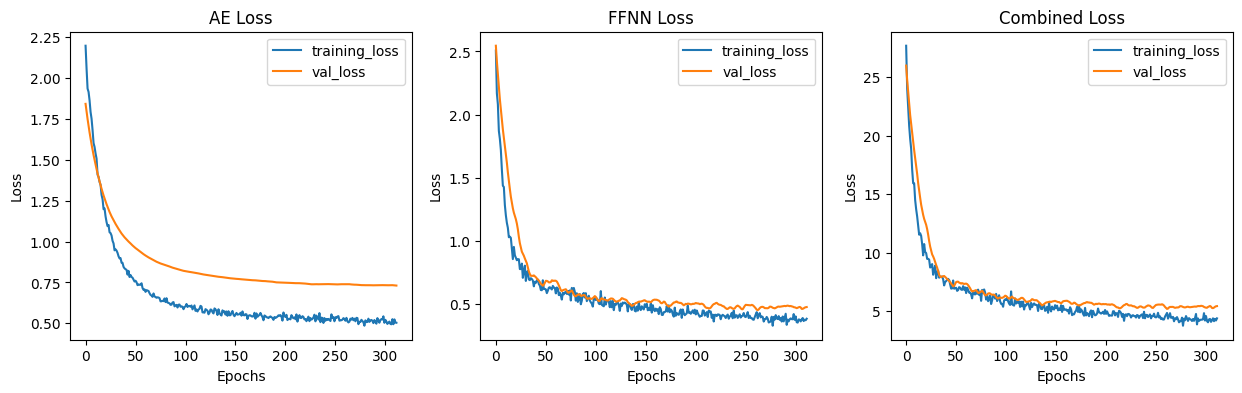

In [47]:
fig,ax = plt.subplots(1,3, figsize = (15,4))
title = ['AE Loss', 'FFNN Loss', 'Combined Loss']
keys = list(history.history.keys())
key_pairs = [(keys[i], keys[i+3]) for i in range(3)]

for i in range(3):
    ax[i].plot(history.history[key_pairs[i][0]], label='training_loss')
    ax[i].plot(history.history[key_pairs[i][1]], label='val_loss')

    ax[i].set_title(title[i])
    ax[i].legend()
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


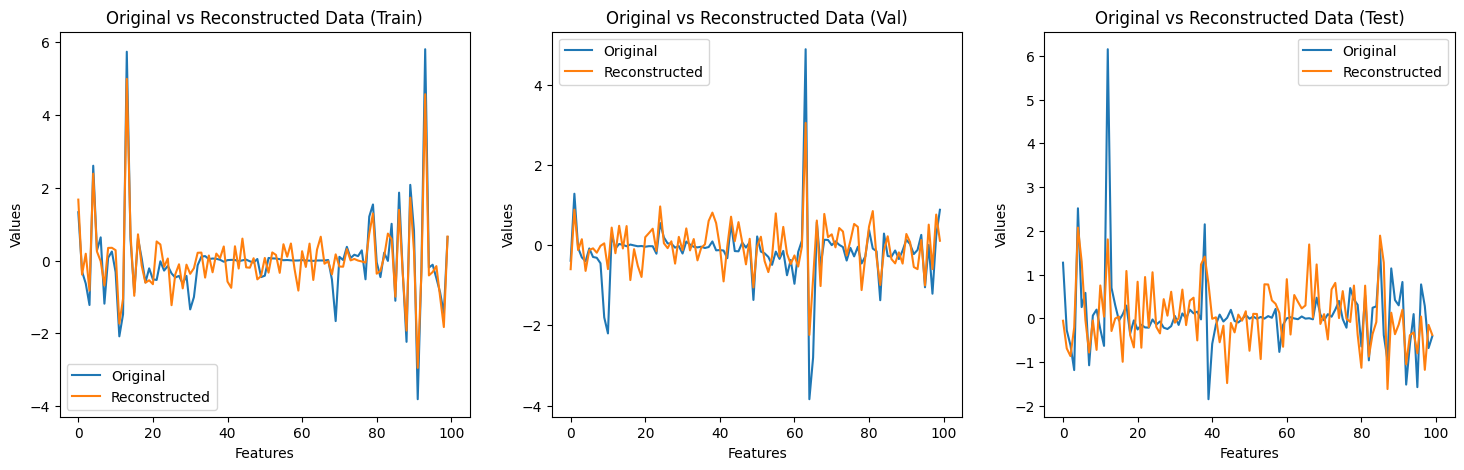

In [48]:
reconstructed_X_train_best = autoencoder_best.predict(X_train)
reconstructed_X_val_best = autoencoder_best.predict(X_val)
reconstructed_X_test_best = autoencoder_best.predict(X_test)

sample_idx_train_best = X_train[0]
sample_idx_val_best = X_val[0]
sample_idx_test_best = X_test[0]

fig, ax = plt.subplots(1,3, figsize = (18,5))

ax[0].plot(X_train[0], label = 'Original')
ax[1].plot(X_val[0], label = 'Original')
ax[2].plot(X_test[0], label = 'Original')

ax[0].plot(reconstructed_X_train_best[0], label = 'Reconstructed')
ax[1].plot(reconstructed_X_val_best[0], label = 'Reconstructed')
ax[2].plot(reconstructed_X_test_best[0], label = 'Reconstructed')

ax[0].set_xlabel('Features')
ax[0].set_ylabel('Values')

ax[1].set_xlabel('Features')
ax[1].set_ylabel('Values')

ax[2].set_xlabel('Features')
ax[2].set_ylabel('Values')

ax[0].set_title('Original vs Reconstructed Data (Train)')
ax[1].set_title('Original vs Reconstructed Data (Val)')
ax[2].set_title('Original vs Reconstructed Data (Test)')

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].set_xlim([-5, X.shape[1]+5])
ax[1].set_xlim([-5, X.shape[1]+5])
ax[2].set_xlim([-5, X.shape[1]+5])

plt.show()

In [49]:
pred_train_best = combined_model_best.predict(X_train)#, [X_train, y_train])
pred_val_best = combined_model_best.predict(X_val)#, [X_val, y_val])
pred_test_best = combined_model_best.predict(X_test)#, [X_test, y_test])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


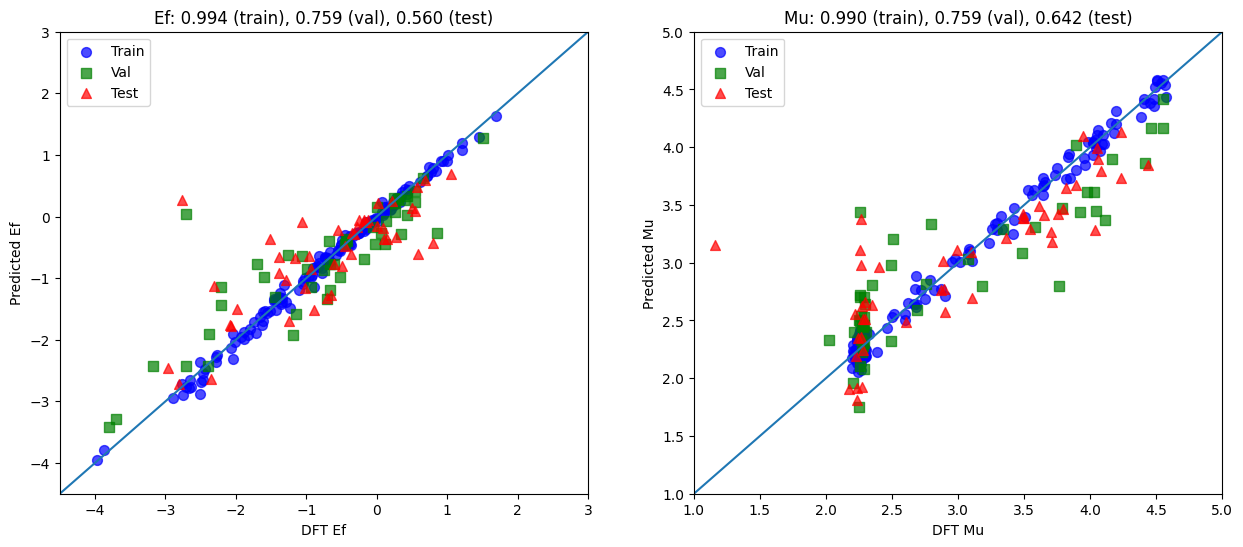

In [50]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (15,6))
ax1.scatter(y_train['Ef_per_cell'], pred_train_best[1][:,0], color = 'blue', alpha = 0.7, s = 50, marker = 'o', label = 'Train')
ax1.scatter(y_val['Ef_per_cell'], pred_val_best[1][:,0], color = 'green', alpha = 0.7, s = 50, marker = 's', label = 'Val')
ax1.scatter(y_test['Ef_per_cell'], pred_test_best[1][:,0], color = 'red', alpha = 0.7, s = 50, marker = '^', label = 'Test')
ax1.plot([-4.5, 3], [-4.5, 3])

ax2.scatter(y_train['Mu_per_cell'], pred_train_best[1][:,1], color = 'blue', alpha = 0.7, s = 50, marker = 'o', label = 'Train')
ax2.scatter(y_val['Mu_per_cell'], pred_val_best[1][:,1], color = 'green', alpha = 0.7, s = 50, marker = 's', label = 'Val')
ax2.scatter(y_test['Mu_per_cell'], pred_test_best[1][:,1], color = 'red', alpha = 0.7, s = 50, marker = '^', label = 'Test')
ax2.plot([0, 5], [0, 5])

ax1.set_title('Ef: {:.3f} (train), {:.3f} (val), {:.3f} (test)'.format(metrics.r2_score(y_train['Ef_per_cell'], pred_train_best[1][:,0]),metrics.r2_score(y_val['Ef_per_cell'], pred_val_best[1][:,0]),metrics.r2_score(y_test['Ef_per_cell'], pred_test_best[1][:,0])))
ax2.set_title('Mu: {:.3f} (train), {:.3f} (val), {:.3f} (test)'.format(metrics.r2_score(y_train['Mu_per_cell'], pred_train_best[1][:,1]),metrics.r2_score(y_val['Mu_per_cell'], pred_val_best[1][:,1]),metrics.r2_score(y_test['Mu_per_cell'], pred_test_best[1][:,1])))

ax1.set_xlabel('DFT Ef')
ax1.set_ylabel('Predicted Ef')

ax2.set_xlabel('DFT Mu')
ax2.set_ylabel('Predicted Mu')

ax1.set_xlim([-4.5, 3])
ax1.set_ylim([-4.5, 3])

ax2.set_xlim([1, 5])
ax2.set_ylim([1, 5])

ax1.legend()
ax2.legend()

plt.show()

In [51]:
r2_train_ef_best = metrics.r2_score(y_train['Ef_per_cell'], pred_train_best[1][:,0])
r2_train_mu_best = metrics.r2_score(y_train['Mu_per_cell'], pred_train_best[1][:,1])

r2_val_ef_best = metrics.r2_score(y_val['Ef_per_cell'], pred_val_best[1][:,0])
r2_val_mu_best = metrics.r2_score(y_val['Mu_per_cell'], pred_val_best[1][:,1])

r2_test_ef_best = metrics.r2_score(y_test['Ef_per_cell'], pred_test_best[1][:,0])
r2_test_mu_best = metrics.r2_score(y_test['Mu_per_cell'], pred_test_best[1][:,1])

mae_train_ef_best = metrics.mean_absolute_error(y_train['Ef_per_cell'], pred_train_best[1][:,0])
mae_train_mu_best = metrics.mean_absolute_error(y_train['Mu_per_cell'], pred_train_best[1][:,1])

mae_val_ef_best = metrics.mean_absolute_error(y_val['Ef_per_cell'], pred_val_best[1][:,0])
mae_val_mu_best = metrics.mean_absolute_error(y_val['Mu_per_cell'], pred_val_best[1][:,1])

mae_test_ef_best = metrics.mean_absolute_error(y_test['Ef_per_cell'], pred_test_best[1][:,0])
mae_test_mu_best = metrics.mean_absolute_error(y_test['Mu_per_cell'], pred_test_best[1][:,1])

width = 10
print(f'{"Properties":>{width+1}} {"R2(Train)":>{width+1}} {"R2(Val)":>{width-1}} {"R2(Test)":>{width}} {"MAE(Train)":>{width+2}} {"MAE(Val)":>{width}} {"MAE(Test)":>{width}}')
print('='*80)
print(f'{"Ef":>{width}} {r2_train_ef_best:>{width}.3f} {r2_val_ef_best:>{width}.3f} {r2_test_ef_best:>{width}.3f} {mae_train_ef_best:>{width}.3f} {mae_val_ef_best:>{width}.3f} {mae_test_ef_best:>{width}.3f}')
print(f'{"Mu":>{width}} {r2_train_mu_best:>{width}.3f} {r2_val_mu_best:>{width}.3f} {r2_test_mu_best:>{width}.3f} {mae_train_mu_best:>{width}.3f} {mae_val_mu_best:>{width}.3f} {mae_test_mu_best:>{width}.3f}')

 Properties   R2(Train)   R2(Val)   R2(Test)   MAE(Train)   MAE(Val)  MAE(Test)
        Ef      0.994      0.759      0.560      0.063      0.401      0.436
        Mu      0.990      0.759      0.642      0.066      0.323      0.328


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


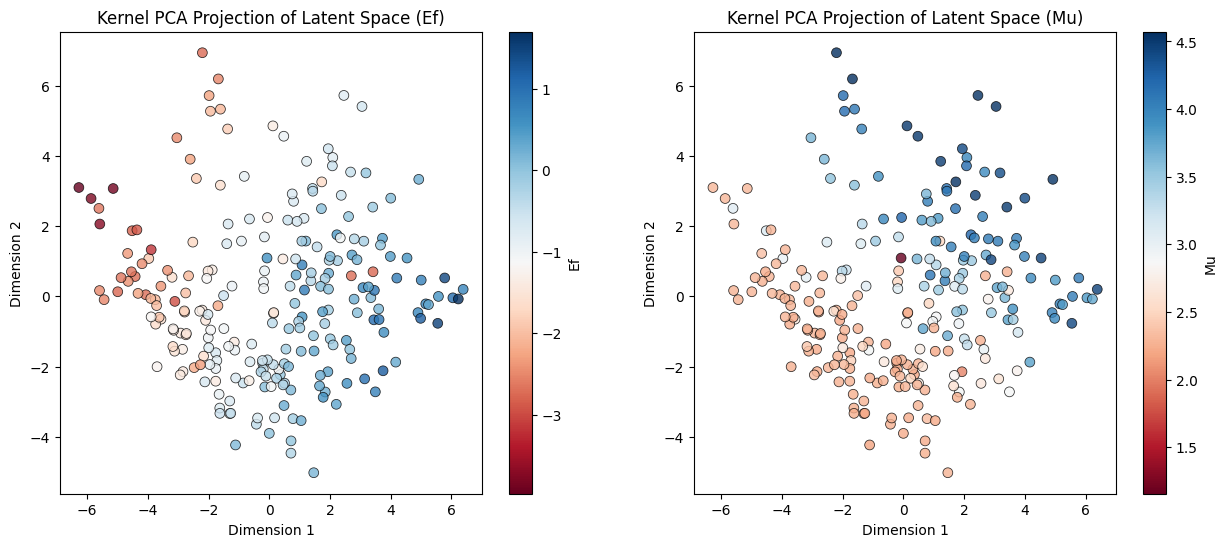

In [52]:
# Extract latent representations
encoder_model_best = Model(inputs = encoder_input_best, outputs = encoder_output_best)
latent_X_best = encoder_model_best.predict(X)

# Apply Kernel PCA
kpca_best = KernelPCA(n_components=2, kernel='linear', gamma=None, fit_inverse_transform=True, alpha=1.0, n_jobs=-1)
kpca_embeddings_best = kpca_best.fit_transform(latent_X_best)

# Create a DataFrame for Seaborn
kpca_df_best = pd.DataFrame(data={'Dimension 1': kpca_embeddings_best[:, 0],
                             'Dimension 2': kpca_embeddings_best[:, 1],
                             'Ef': y['Ef_per_cell'],
                             'Mu': y['Mu_per_cell']})

# Visualize the projected latent space using Seaborn
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
scatter_best_ef = sns.scatterplot(ax=ax[0], data=kpca_df_best, x='Dimension 1', y='Dimension 2', hue='Ef', palette='RdBu', s=50, alpha=0.8, edgecolor='k', legend=False)
scatter_best_mu = sns.scatterplot(ax=ax[1], data=kpca_df_best, x='Dimension 1', y='Dimension 2', hue='Mu', palette='RdBu', s=50, alpha=0.8, edgecolor='k', legend=False)

norm_best_ef = Normalize(vmin=kpca_df_best['Ef'].min(), vmax=kpca_df_best['Ef'].max())
norm_best_mu = Normalize(vmin=kpca_df_best['Mu'].min(), vmax=kpca_df_best['Mu'].max())

sm_best_ef = plt.cm.ScalarMappable(cmap='RdBu', norm=norm_best_ef)
sm_best_mu = plt.cm.ScalarMappable(cmap='RdBu', norm=norm_best_mu)

sm_best_ef.set_array([])
sm_best_mu.set_array([])

cbar_best_ef = fig.colorbar(sm_best_ef, ax=ax[0])
cbar_best_mu = fig.colorbar(sm_best_mu, ax=ax[1])

cbar_best_ef.set_label('Ef')
cbar_best_mu.set_label('Mu')

ax[0].set_title('Kernel PCA Projection of Latent Space (Ef)')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')

ax[1].set_title('Kernel PCA Projection of Latent Space (Mu)')
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')

plt.show()